# Prediction of Day Ahead Energy Price in Spain using Regression
**End-to-End Machine Learning Project**

### Content:

- Executive Summary
- Quick Overview Spanish Energy Market
- EDA
- Feature Engineering and Transformation
- Model Development

## Excecutive Summary
The purpose of this notebook is to develop a machine-learning model to predict day-ahead energy prices for the Spanish Power Market (using Regression techniques). Given the dynamic nature of the energy market and increasing liberalization, correct day-ahead forecasts for energy prices are of increasing importance to energy providers and significantly help in reducing uncertainty and optimizing profits. 
The developed forecasting model takes as input factors energy production for different sources, energy demand as well as seasonality and time-effects. It was trained on actual data for production, demand and prices from 2017-2020.

## Quick overview Spanish Energy Market

The energy sector accounts for approximately 2.5% of Spain's GDP. **The yearly energy consumption in 2020 was roughly 249,716 GWh (-5.6% vs. 2019), which amounts to 5,278kWh per capita. Energy production decreased by -4% vs. 2019 to 250,387 GWh.**
 
Over the past few years, Spain has increasingly invested in **expanding energy production from renewable sources**: in 2020, Spain produced 43.6% of its electricity with renewable technologies (+11.6% vs. 2019), benefiting both from favorable weather conditions as well as an increase in production capacity. Spain’s total installed generation capacity stands at 109,674 MW, with renewables accounting for 53% of the total. Of the 43.6% of energy produced through renewables, wind contributed with a 21.7% share of total generation, hydro with 11.9%, solar photovoltaic (PV) with 6.1% and thermal solar power as well as alternative renewable sources with the remaining 3.9% share of total power generation. Further energy sources are nuclear (22.2%), combined cycle (17.8%), cogeneration (10.8%) and coal (2.0%) as well as other sources (3.6%). (see graphic below). Of the non-renewable sources, all but nuclear reduced their share of total energy production in order to enable the shift to greener (and cheaper) energy.

To optimally manage its energy production and demand, Spain complements its electricity system through **pyhsical energy exchange**. In 2020, Spain's import balance was at 3,857 GWh (-43.8% vs. 2019), resulting from 18,687 GWh of import and 14,830 GWh of export carried out during this year.

The **Spanish electricity market is organized through a bidding process**: every day, energy producers share their offers for energy prices (per hour of the day) based on their predicted energy production and electricity providers their bids, based on their energy demand prediction. The three main players (Iberdrola, Gas Natural Fenosa and Grupo Endesa dominate the market with ca.50% market share. 

**Energy prices in Spain have been continously decrasing over recent years**, mainly due to a shift to lower-cost energy production (renewables). In 2020, energy prices have also been strongly influenced by the Covid-19 pandemic: the decrease of -5.6% in energy consumption further increased the downward trend in electriticy prices. Average electricity price in Spain in 2020 was 40,37 €/MWh, down from 47,71 €/MWh in 2019 (-15.4% YoY) and much lower than 2018 (57,34 €/MWh). 
As of the date of when this repor was written (April 05, 2021), the average value of the electricity price in Spain is 44,55€/MWh.

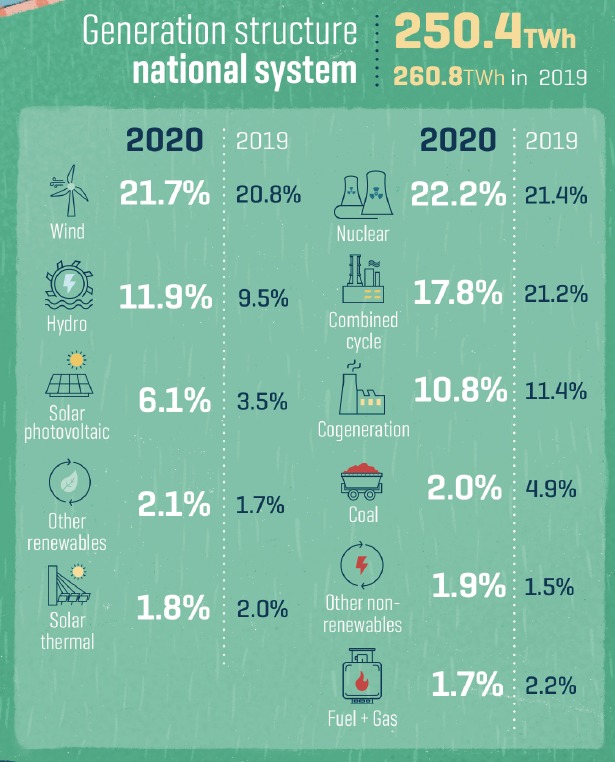

[Source](https://www.ree.es/sites/default/files/11_PUBLICACIONES/Documentos/InformesSistemaElectrico/2020/Preliminary_report_2020_Forecasting_data.pdf)

# 0. Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

In [4]:
# Change display of numbers to float format (instead of scientific format)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 1. Importing Dataset

The dataset contains the following timeseries with hourly data for:

- date: date of the observation ”%Y-%m-%d”
- hour: hour of the observation, [0 - 23]
- fc demand: forecast of demand in MWh
- fc nuclear: forecast of nuclear power production in MWh
- import FR: forecast of the importing capacity from France to Spain in MWh
- export FR: forecast of the exporting capacity from Spain to France in MWh
- fc wind: forecast of wind power production in MWh
- fc solar pv: forecast of PV solar (solar panels) power production in MWh
- fc solar th: forecast of thermal solar power production in MWh
- price: power price for each hour in €/MWh. This is the target variable we want to predict.


In [5]:
url = "https://gist.githubusercontent.com/frau-web/e1bc3ace36c9e2a1cf8298b280b539e1/raw/bd64677c61475396d427c98c7229944ab953660a/power_market.csv"
df = pd.read_csv(url)

In [6]:
df.head()

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0  24400.000    7117.200   3000.000   2600.000 1732.000        0.000   
1  23616.000    7117.200   3000.000   2650.000 1826.000        0.000   
2  21893.000    7117.200   3000.000   2650.000 1823.000        0.000   
3  20693.000    7117.200   3000.000   2650.000 1777.000        0.000   
4  19599.000    7117.200   3000.000   2650.000 1746.000        0.000   

   fc_solar_th  price        date  hour  
0        5.100 58.820  2017-01-01     0  
1        0.600 58.230  2017-01-01     1  
2        4.600 51.950  2017-01-01     2  
3        9.700 47.270  2017-01-01     3  
4       24.100 45.490  2017-01-01     4

# 2. Exploring the Data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fc_demand    32135 non-null  float64
 1   fc_nuclear   32135 non-null  float64
 2   import_FR    32122 non-null  float64
 3   export_FR    32122 non-null  float64
 4   fc_wind      32135 non-null  float64
 5   fc_solar_pv  32135 non-null  float64
 6   fc_solar_th  32135 non-null  float64
 7   price        32135 non-null  float64
 8   date         32135 non-null  object 
 9   hour         32135 non-null  int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 2.5+ MB


In [8]:
df.shape # Get number of rows and columns of the dataframe

(32135, 10)

In [9]:
duplicateRowsDF = df[df.duplicated()]
#print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)

Empty DataFrame
Columns: [fc_demand, fc_nuclear, import_FR, export_FR, fc_wind, fc_solar_pv, fc_solar_th, price, date, hour]
Index: []


We have 32,135 observations and 10 columns and no duplicates: the target variable (price) and 9 features to work with. Let's analyze each of them in order to identify if clearning or preprocessing is needed: 

In [11]:
# inspecting summary stats
# power_market_df.describe()
# Construct a dataframe with the metainfo of the dataset
pd.set_option("precision", 3) # Change precision of float numbers to 3 digits
df_info = pd.DataFrame(df.dtypes)
df_info["missing"] = df.isnull().sum()
df_info["unique"] = df.nunique()
df_info["count"] = df.count()
df_info["min"] = df.min()
df_info["max"] = df.max()
df_info["mean"] = df.mean()
df_info["median"] = df.median()
df_info["stdev"] = df.std()
df_info

0  missing  unique  count         min         max  \
fc_demand    float64        0   14956  32135   16372.000   41103.000   
fc_nuclear   float64        0     223  32135    3672.800    7117.200   
import_FR    float64       13      57  32122     700.000    3700.000   
export_FR    float64       13      61  32122     200.000    3700.000   
fc_wind      float64        0   11379  32135     139.000   17232.000   
fc_solar_pv  float64        0   14346  32135       0.000    7211.200   
fc_solar_th  float64        0   13034  32135       0.000    2253.700   
price        float64        0    5871  32135       0.030     101.990   
date          object        0    1339  32135  2017-01-01  2020-08-31   
hour           int64        0      24  32135           0          23   

                 mean    median    stdev  
fc_demand   28475.594 28446.000 4686.676  
fc_nuclear   6421.333  7117.200  862.355  
import_FR    2445.285  2450.000  623.215  
export_FR    2217.865  2200.000  550.563  
fc_wind      5627.215  4989.000 3266.962  
fc_solar_pv  1100.254   107.800 1512.532  
fc_solar_th   601.187   331.400  681.585  
price          48.440    49.880   14.842  
date              nan       nan      nan  
hour           11.500    12.000    6.922

**Quick Insights**: 
- Datatype: we need to change the datatype of (`date`) to date type as it appears as a categorical
- Missing values: our dataset appears almost complete, there is only 13 missing values for both (`import_FR`) and (`export_FR`) (<0.1%)
- Distribution: We can observe that the energy sources and demand have relatively high standard deviations as well as skewness. Both can be explained through the nature of energy production
- Date range: We observe that (`date`) min and max values are 2017-01-01 and 2020-08-30, respectively, which provides us the range of the timeseries we are dealing with

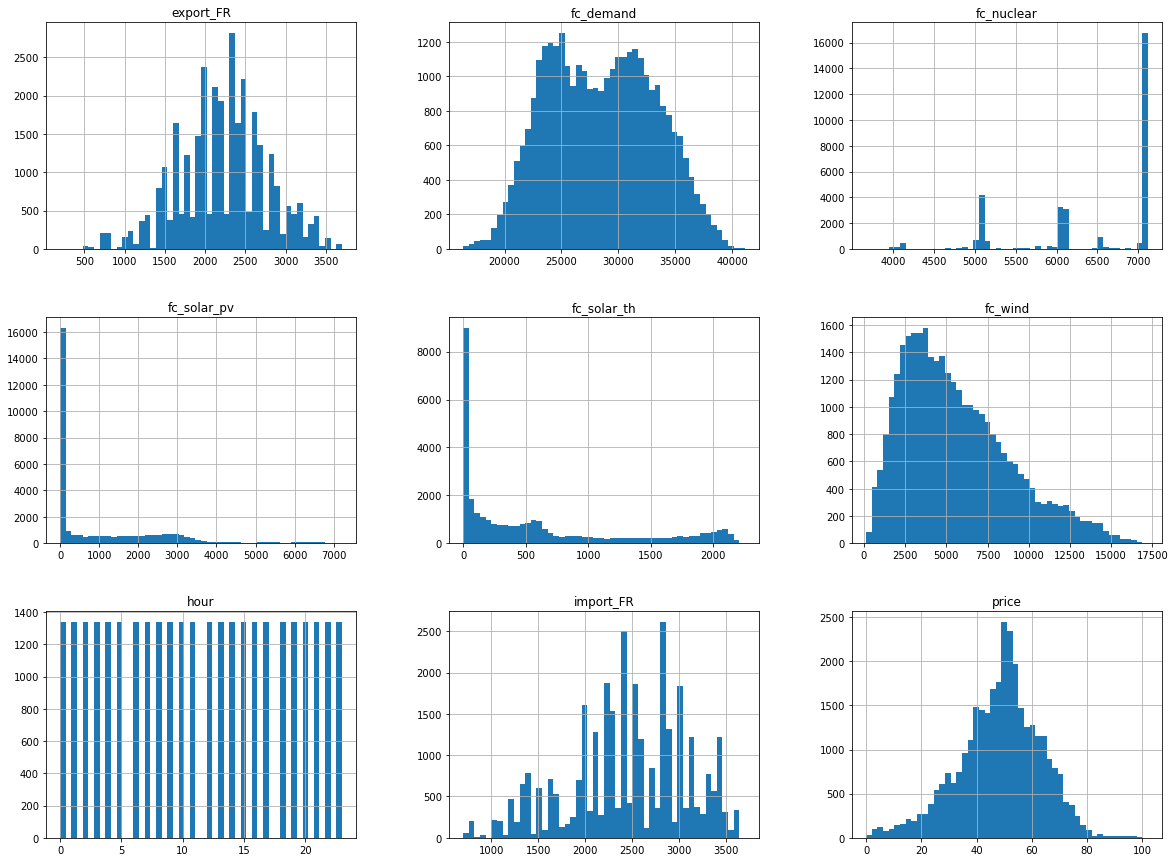

In [12]:
# Analyze Distribution
df.hist(bins=50,figsize=(20,15));

We have several different types of variables:

- time related data: (`date`), (`hour`)
- energy production forecasts: (`fc_nuclear`),(`fc_wind`),(`fc_solar_pv`), (`fc_solar_th`) 
- forecasted energy demand & import/export related data: (`fc_demand`),(`import_FR`), (`export_FR`)
- Energy Price: (`price`)

In the following, we will explore each of these types in detail

In [15]:
# Keep df before new feature creation as baseline for model development
df_raw = df.copy()

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0  24400.000    7117.200   3000.000   2600.000 1732.000        0.000   
1  23616.000    7117.200   3000.000   2650.000 1826.000        0.000   
2  21893.000    7117.200   3000.000   2650.000 1823.000        0.000   
3  20693.000    7117.200   3000.000   2650.000 1777.000        0.000   
4  19599.000    7117.200   3000.000   2650.000 1746.000        0.000   

   fc_solar_th  price       date  hour  
0        5.100 58.820 2017-01-01     0  
1        0.600 58.230 2017-01-01     1  
2        4.600 51.950 2017-01-01     2  
3        9.700 47.270 2017-01-01     3  
4       24.100 45.490 2017-01-01     4

### Time-related data

In [13]:
# What we already know
df_info.loc[["date","hour"]]

0  missing  unique  count         min         max   mean  median  \
date  object        0    1339  32135  2017-01-01  2020-08-31    nan     nan   
hour   int64        0      24  32135           0          23 11.500  12.000   

      stdev  
date    nan  
hour  6.922

We notice that (`date`) is not properly encoded. Since we are dealing with timeseries oriented data structures, we can convert it to (`datetime`) before further processing. 

In [14]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [15]:
# Sense-check

#df["date"].unique()
#df["hour"].unique()
#df["hour"].value_counts()

Let's extract further time-related features that will help in gaining a better understanding of the other variables and which will also be used as features in our machine learning model. Specifically, we extract year, month, day of the week and the combination of year & month: 

In [16]:
# Extracting datetimes
df['year']= pd.DatetimeIndex(df['date']).year
df['month']= pd.DatetimeIndex(df['date']).month
# df['day']= pd.DatetimeIndex(df['date']).day
df['day_of_week']=pd.DatetimeIndex(df['date']).dayofweek

df['year_month'] = df['date'].dt.to_period('M')

### Energy production Forecasts

In [17]:
# What we already know
df_info.loc[["fc_nuclear", "fc_wind", "fc_solar_pv", "fc_solar_th"]]

0  missing  unique  count      min       max     mean  \
fc_nuclear   float64        0     223  32135 3672.800  7117.200 6421.333   
fc_wind      float64        0   11379  32135  139.000 17232.000 5627.215   
fc_solar_pv  float64        0   14346  32135    0.000  7211.200 1100.254   
fc_solar_th  float64        0   13034  32135    0.000  2253.700  601.187   

              median    stdev  
fc_nuclear  7117.200  862.355  
fc_wind     4989.000 3266.962  
fc_solar_pv  107.800 1512.532  
fc_solar_th  331.400  681.585

These statistics already give a hint on the distribution of forecasted energy production: Nuclear and wind energy production are never zero, thus their production is never stopped while solar energy can be zero, especially at night. 

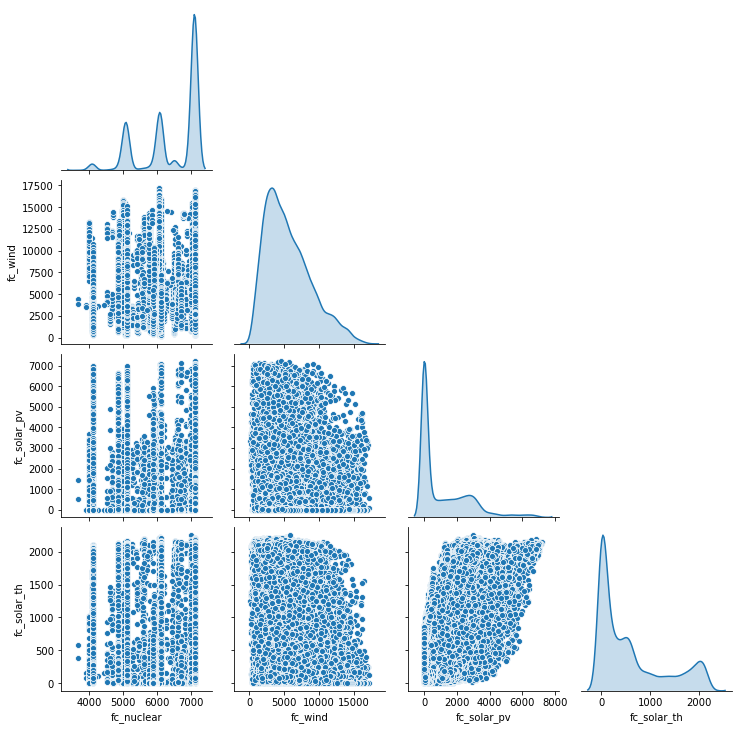

In [18]:
# Check Distributions & Pairwise interactions
sns.pairplot(df[["fc_nuclear", "fc_wind", "fc_solar_pv", "fc_solar_th"]], diag_kind="kde", corner=True);

#### Nuclear

From the data given, we can conclude that nuclear energy is produced most of the time at the max capacity level of 7,000 MWh and that up- or down-scaling is performed stepwise, or in blocks around 4000,5000,6000 and 7000 MWh.
Ca 50% of the records in our time-series are nuclear energy forecast at 7,117 MWh. We can observe some seasonal patterns with full capacity during the months of January, February, August and September whereas May and Novembers seems to run at a reduced rate of around 5,000 MWh. This is most likely due to weather patterns requiring high amounts of energy during cold winter months (January, February from heating) and during hot summer months (August, September from the AC) whereas less energy is required during the months of May and November. The months in-between display a large range of production levels. The nuclear production mix could further be influenced through the mix of available production during these months (e.g. more wind energy production results in a lower demand from nuclear sources).
Based on these findings we conclude that we should consider seasonality in our forecasting model.
On the contrary, nuclear energy production is stable throughout the day.

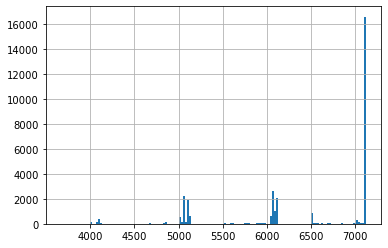

In [19]:
df["fc_nuclear"].hist(bins=150);

In [20]:
df["fc_nuclear"].value_counts()

7117.200    16575
6071.900     2639
6105.900     1051
5110.100     1004
6121.400      862
            ...  
6151.400        1
5180.100        1
6684.400        1
4936.200        1
5151.100        1
Name: fc_nuclear, Length: 223, dtype: int64

Text(0, 0.5, 'Nuclear')

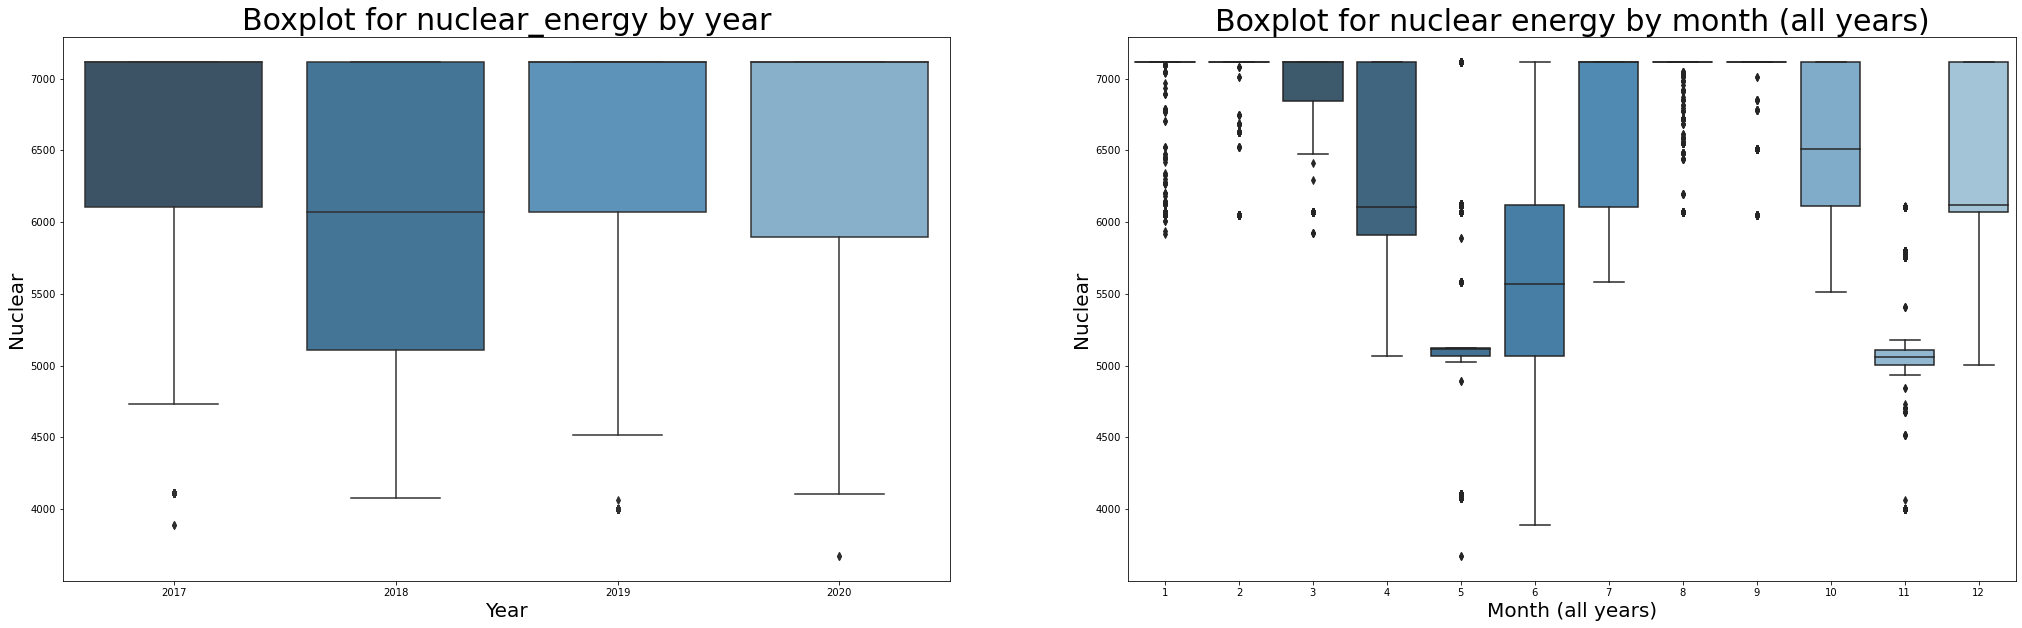

In [21]:
# Analyzing Energy Production by Year and by Month 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(35, 10))

sns.boxplot(x="year", y="fc_nuclear", data=df, ax=ax1, palette="Blues_d")
ax1.set_title("Boxplot for nuclear_energy by year",fontsize = 30)
ax1.set_xlabel("Year" , fontsize = 20)
ax1.set_ylabel("Nuclear" , fontsize = 20)

sns.boxplot(x="month", y="fc_nuclear", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for nuclear energy by month (all years)",fontsize = 30)
ax2.set_xlabel("Month (all years)" , fontsize = 20)
ax2.set_ylabel("Nuclear" , fontsize = 20)

Text(0, 0.5, 'Nuclear')

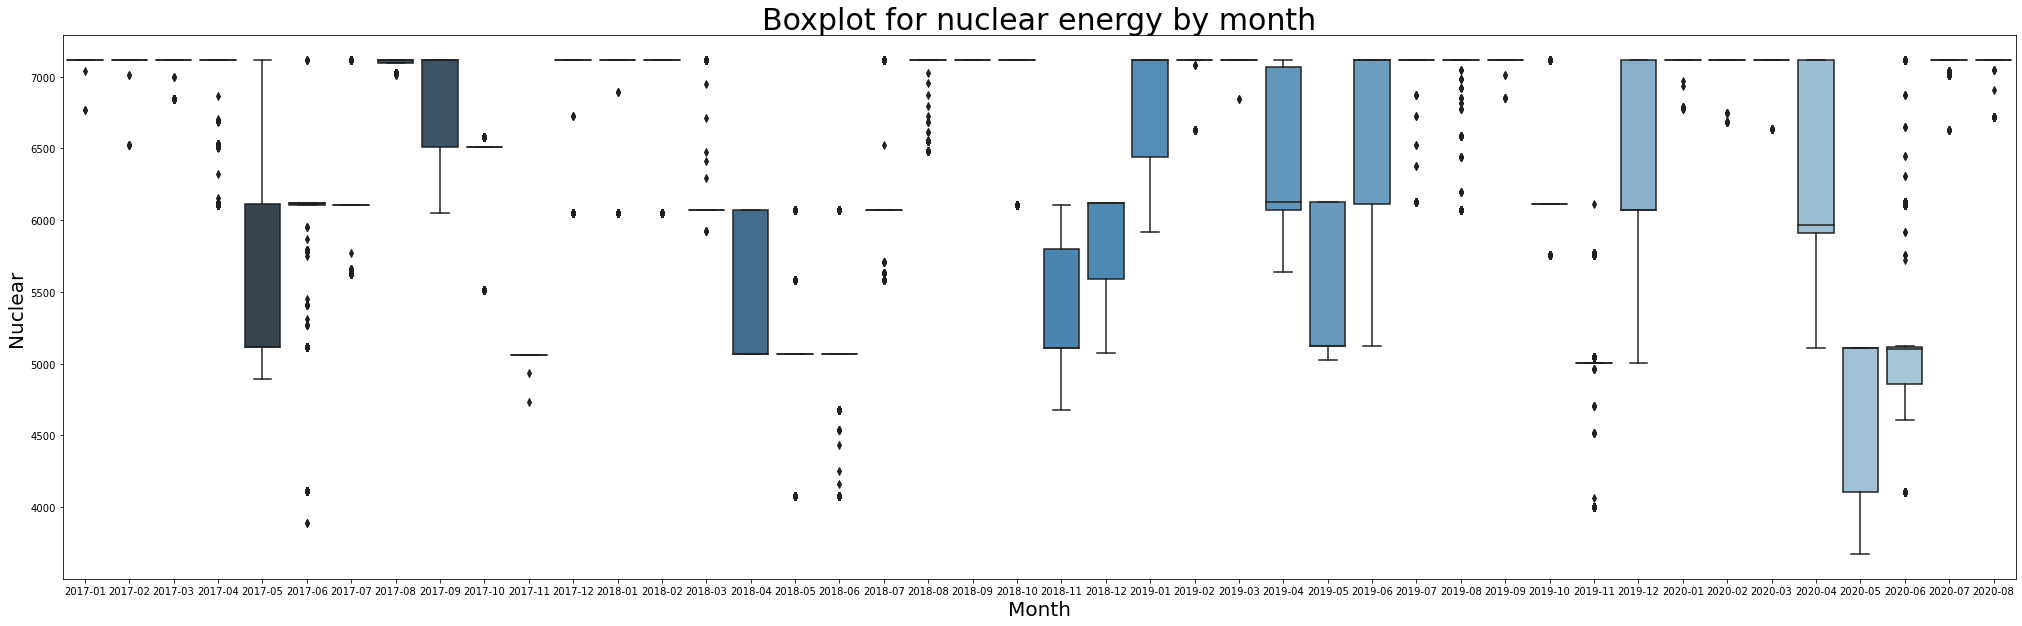

In [22]:
# Analyzing Energy Production by Year and by Month 
fig, (ax2) = plt.subplots(ncols=1, figsize=(35, 10))


sns.boxplot(x="year_month", y="fc_nuclear", data=df, ax=ax2, palette="Blues_d");
ax2.set_title("Boxplot for nuclear energy by month",fontsize = 30)
ax2.set_xlabel("Month" , fontsize = 20)
ax2.set_ylabel("Nuclear" , fontsize = 20)

Text(0, 0.5, 'Solar PV')

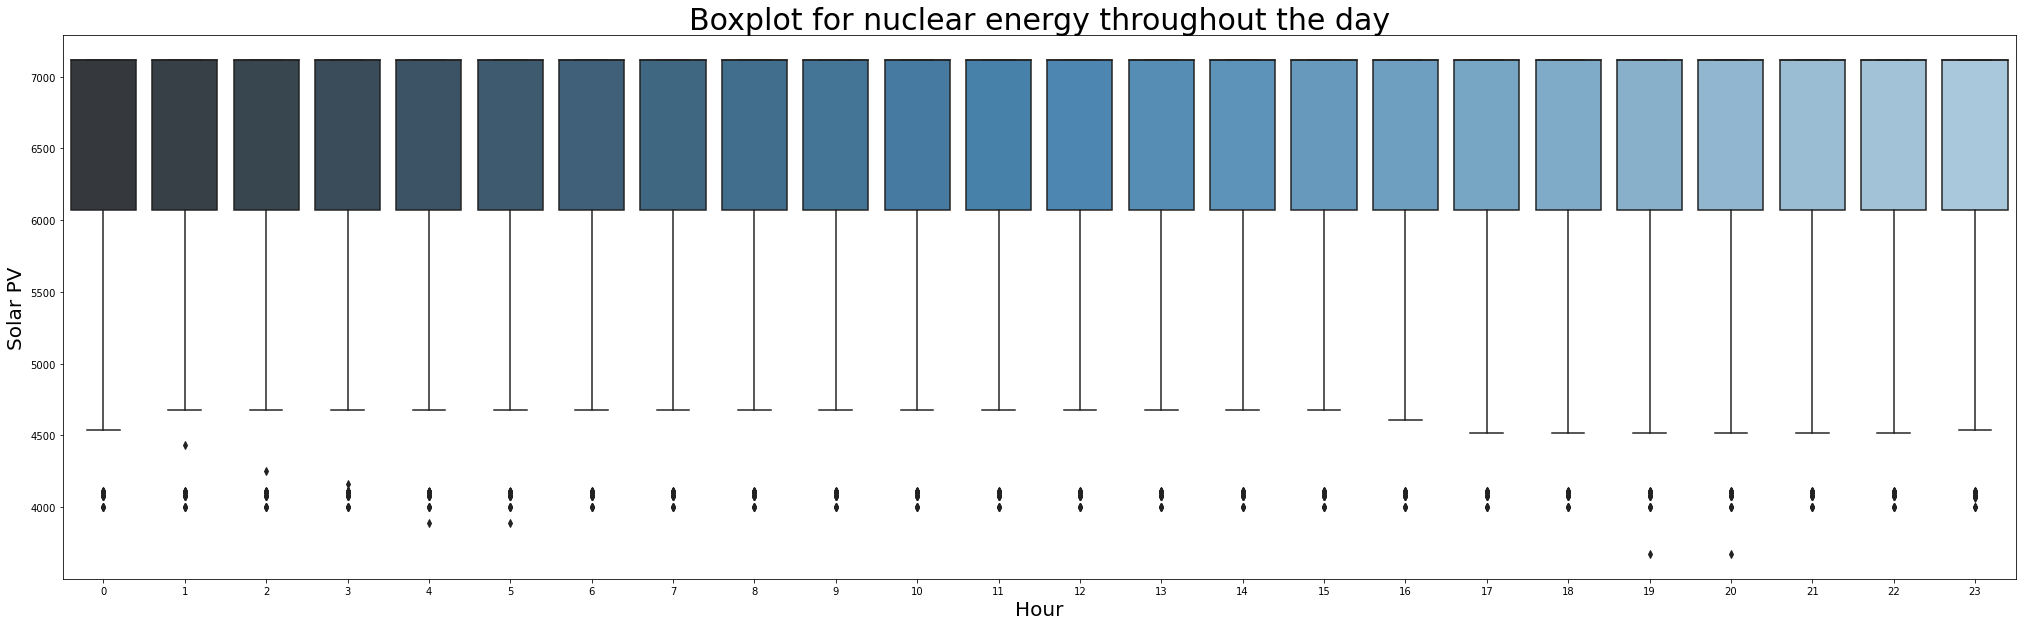

In [23]:
# Analyzing Energy Production throughout the day
fig, (ax2) = plt.subplots(ncols=1, figsize=(35, 10))

sns.boxplot(x="hour", y="fc_nuclear", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for nuclear energy throughout the day",fontsize = 30)
ax2.set_xlabel("Hour" , fontsize = 20)
ax2.set_ylabel("Solar PV" , fontsize = 20)

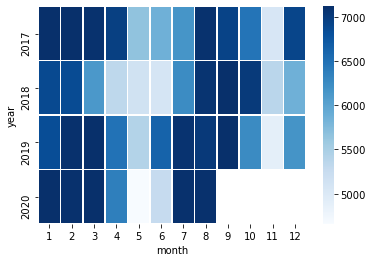

In [24]:
# How does energy production differ by month and year

data = df.groupby(["year","month"])["fc_nuclear"].agg("mean").unstack().sort_index()
plt.figsize = (20,20)
sns.heatmap(data, cmap='Blues', linewidth=0.5);


In [25]:
### Outliers

## Define Function to return outliers

# Define outlier range
outlier_range = 1.5 #x times Interquartile Range (IQR)

# Function to return upper and lower border for outliers
def get_borders(col): 
    sorted(col) 
    Q1,Q3 = np.percentile(col , [25,75]) 
    IQR = Q3-Q1 
    lower_range = Q1-(outlier_range * IQR) 
    upper_range = Q3+(outlier_range * IQR) 
    return lower_range,upper_range

In [26]:
## Check Outliers
col = "fc_nuclear"
lowerbound,upperbound = get_borders(df[col]) # using above pre-defined function 
outliers = pd.DataFrame(df[(df[col] < lowerbound) | (df[col] > upperbound)][col])

# Print outliers
# outliers

# Get number of outliers
outliers.shape

(728, 1)

#### Wind

Wind production is dependent on the forces of nature and it shows a cyclical pattern throughout the year with lower wind energy production during summer months (June to November) and higher wind production throughout the winter months (November to March). Wind production is only little influenced by the hour of the day (less stronger winds during late mornings and early midday; it is never zero.

In [27]:
df["fc_wind"].value_counts()

2329.000     15
2863.000     14
2502.000     13
3923.000     13
3728.000     12
             ..
14546.000     1
2326.000      1
14217.000     1
12878.000     1
1408.000      1
Name: fc_wind, Length: 11379, dtype: int64

Text(0, 0.5, 'Wind')

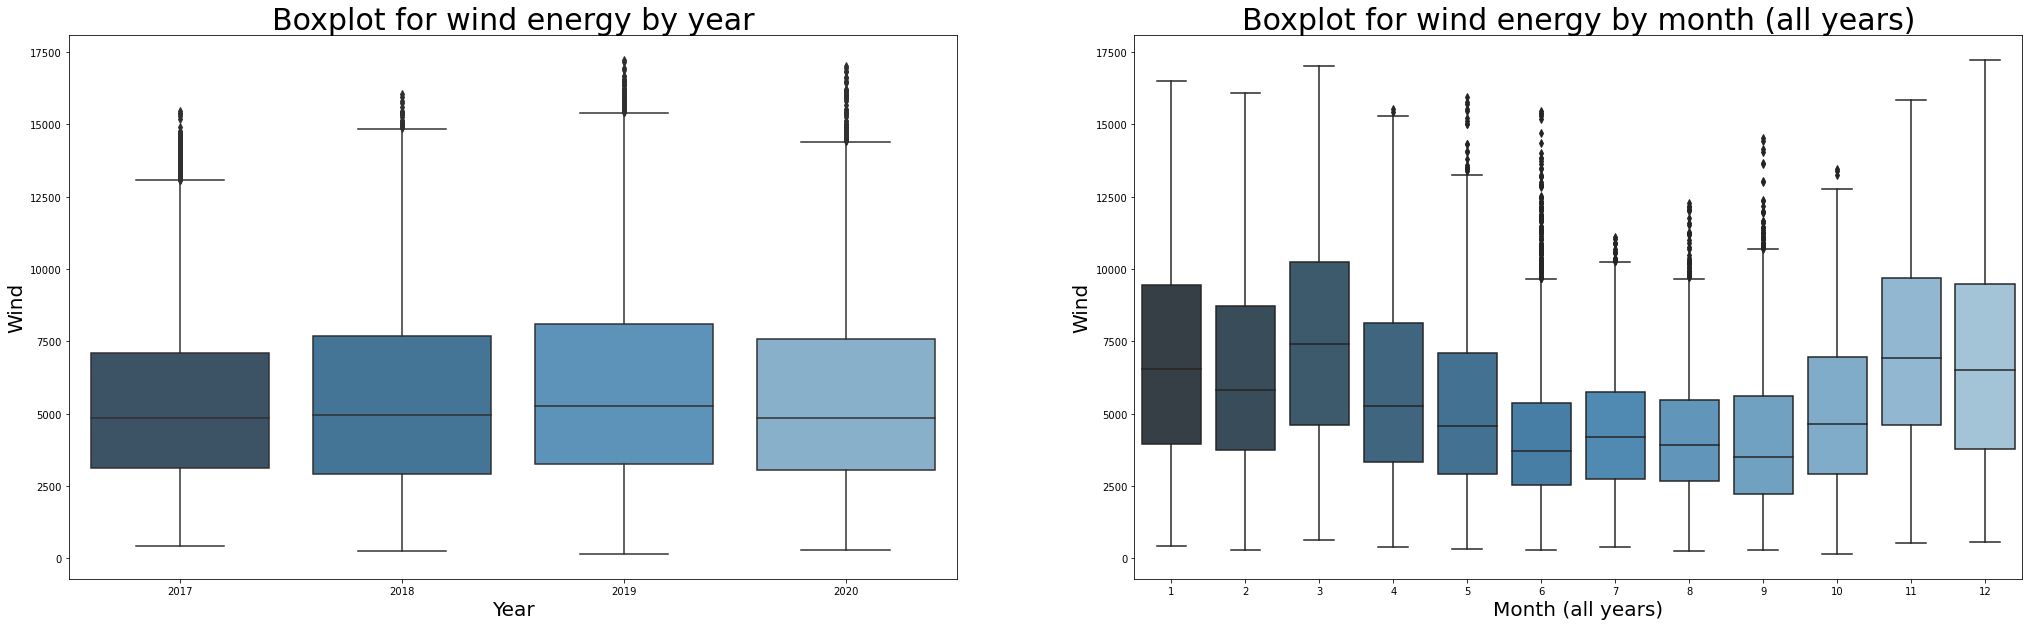

In [28]:
# Analyzing Energy Production by Year and by Month 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(35, 10))

sns.boxplot(x="year", y="fc_wind", data=df, ax=ax1, palette="Blues_d")
ax1.set_title("Boxplot for wind energy by year",fontsize = 30)
ax1.set_xlabel("Year" , fontsize = 20)
ax1.set_ylabel("Wind" , fontsize = 20)

sns.boxplot(x="month", y="fc_wind", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for wind energy by month (all years)",fontsize = 30)
ax2.set_xlabel("Month (all years)" , fontsize = 20)
ax2.set_ylabel("Wind" , fontsize = 20)

Text(0, 0.5, 'Wind')

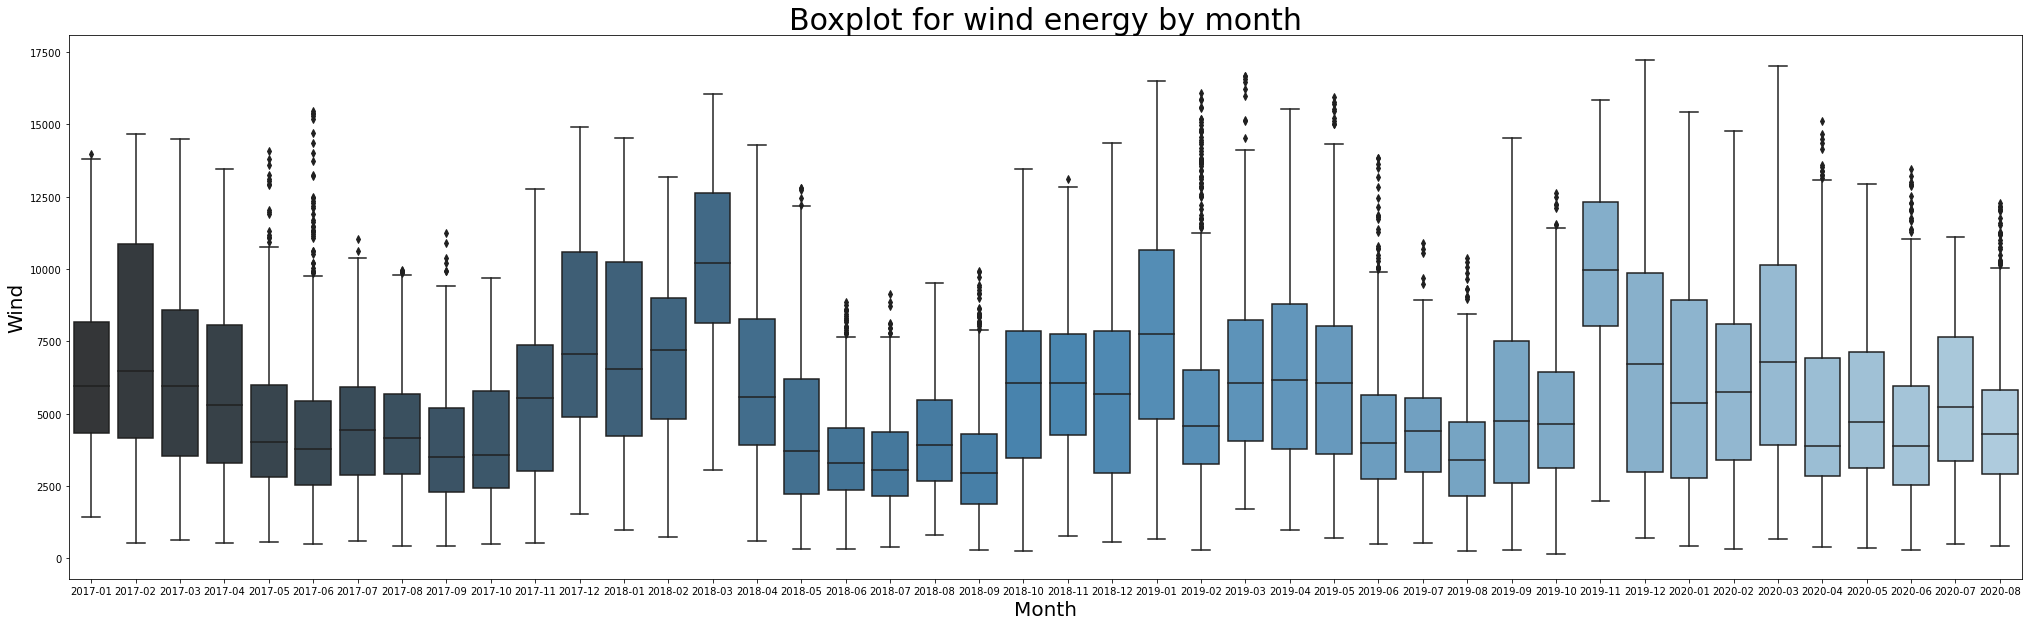

In [29]:
# Analyzing Energy Production by Year and by Month 
fig, (ax2) = plt.subplots(ncols=1, figsize=(35, 10))

sns.boxplot(x="year_month", y="fc_wind", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for wind energy by month",fontsize = 30)
ax2.set_xlabel("Month" , fontsize = 20)
ax2.set_ylabel("Wind" , fontsize = 20)

Text(0, 0.5, 'Wind')

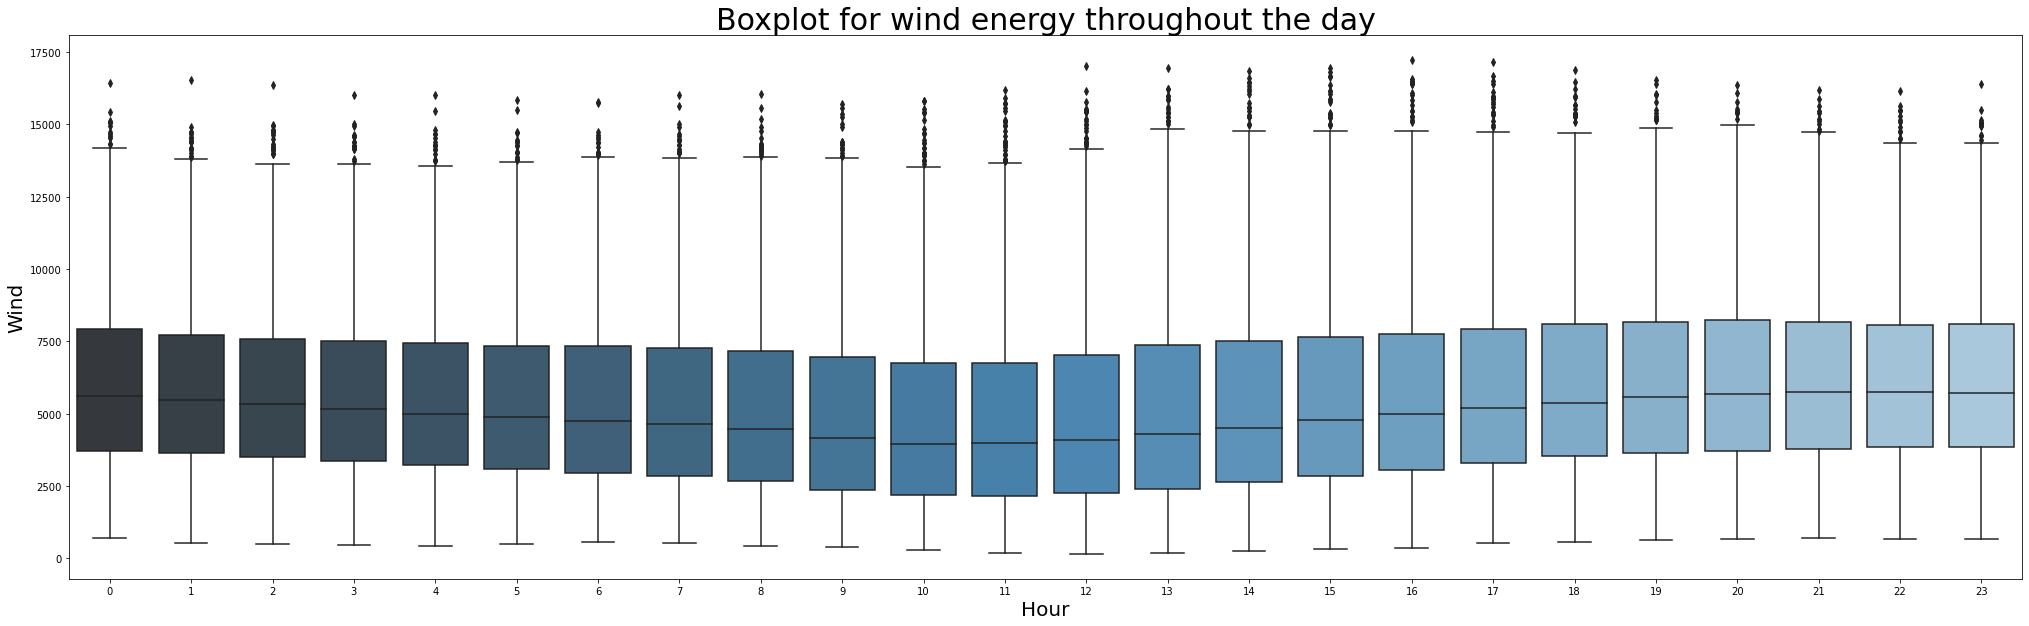

In [30]:
# Analyzing Energy Production throughout the day
fig, (ax2) = plt.subplots(ncols=1, figsize=(35, 10))

sns.boxplot(x="hour", y="fc_wind", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for wind energy throughout the day",fontsize = 30)
ax2.set_xlabel("Hour" , fontsize = 20)
ax2.set_ylabel("Wind" , fontsize = 20)

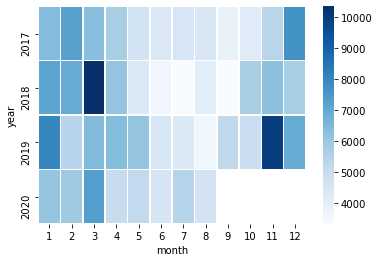

In [31]:
# How does energy production differ by month and year

data = df.groupby(["year","month"])["fc_wind"].agg("mean").unstack().sort_index()
plt.figsize = (20,20)
sns.heatmap(data, cmap='Blues', linewidth=0.5);


In [32]:
# Check Outliers
col = "fc_wind"
lowerbound,upperbound = get_borders(df[col]) # using above pre-defined function 
outliers = pd.DataFrame(df[(df[col] < lowerbound) | (df[col] > upperbound)][col])

# Print outliers
# outliers

# Get number of outliers
outliers.shape

(347, 1)

#### PV Solar

As wind, PV Solar energy is also very much dependent on nature, more specifically on sun: As such, PV Solar energy can only be generated during the hours with daylight and during summer times more PV solar energy is created due to a stronger sun and more hours with daylight. In 2020, we can observe an increase in the PV solar energy produced vs. the same months in previous years - this is most likely due to an increase in the production capacity for PV Solar. 

In [33]:
df["fc_solar_pv"].value_counts()

0.000       13566
0.100          39
0.200          34
0.400          31
0.300          29
            ...  
2363.700        1
6619.000        1
1511.500        1
473.300         1
39.100          1
Name: fc_solar_pv, Length: 14346, dtype: int64

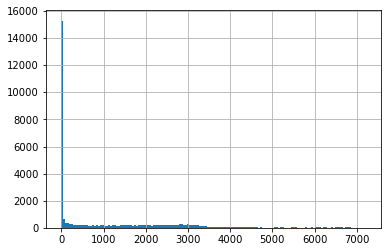

In [34]:
df["fc_solar_pv"].hist(bins=150);

Text(0, 0.5, 'Solar PV')

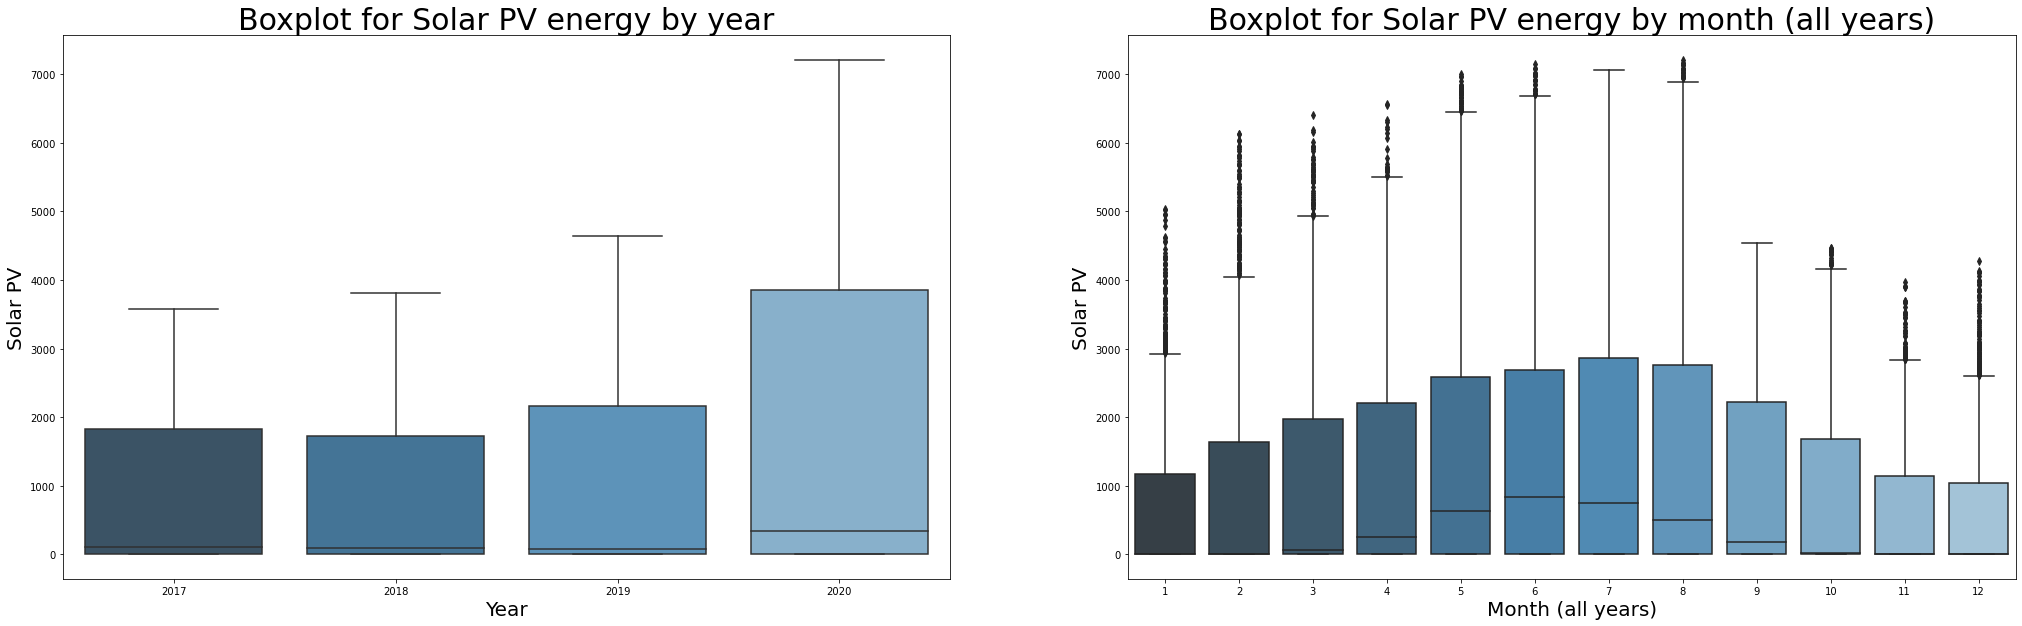

In [36]:
# Analyzing Energy Production by Year and by Month 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(35, 10))

sns.boxplot(x="year", y="fc_solar_pv", data=df, ax=ax1, palette="Blues_d")
ax1.set_title("Boxplot for Solar PV energy by year",fontsize = 30)
ax1.set_xlabel("Year" , fontsize = 20)
ax1.set_ylabel("Solar PV" , fontsize = 20)

sns.boxplot(x="month", y="fc_solar_pv", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for Solar PV energy by month (all years)",fontsize = 30)
ax2.set_xlabel("Month (all years)" , fontsize = 20)
ax2.set_ylabel("Solar PV" , fontsize = 20)

Text(0, 0.5, 'Solar PV')

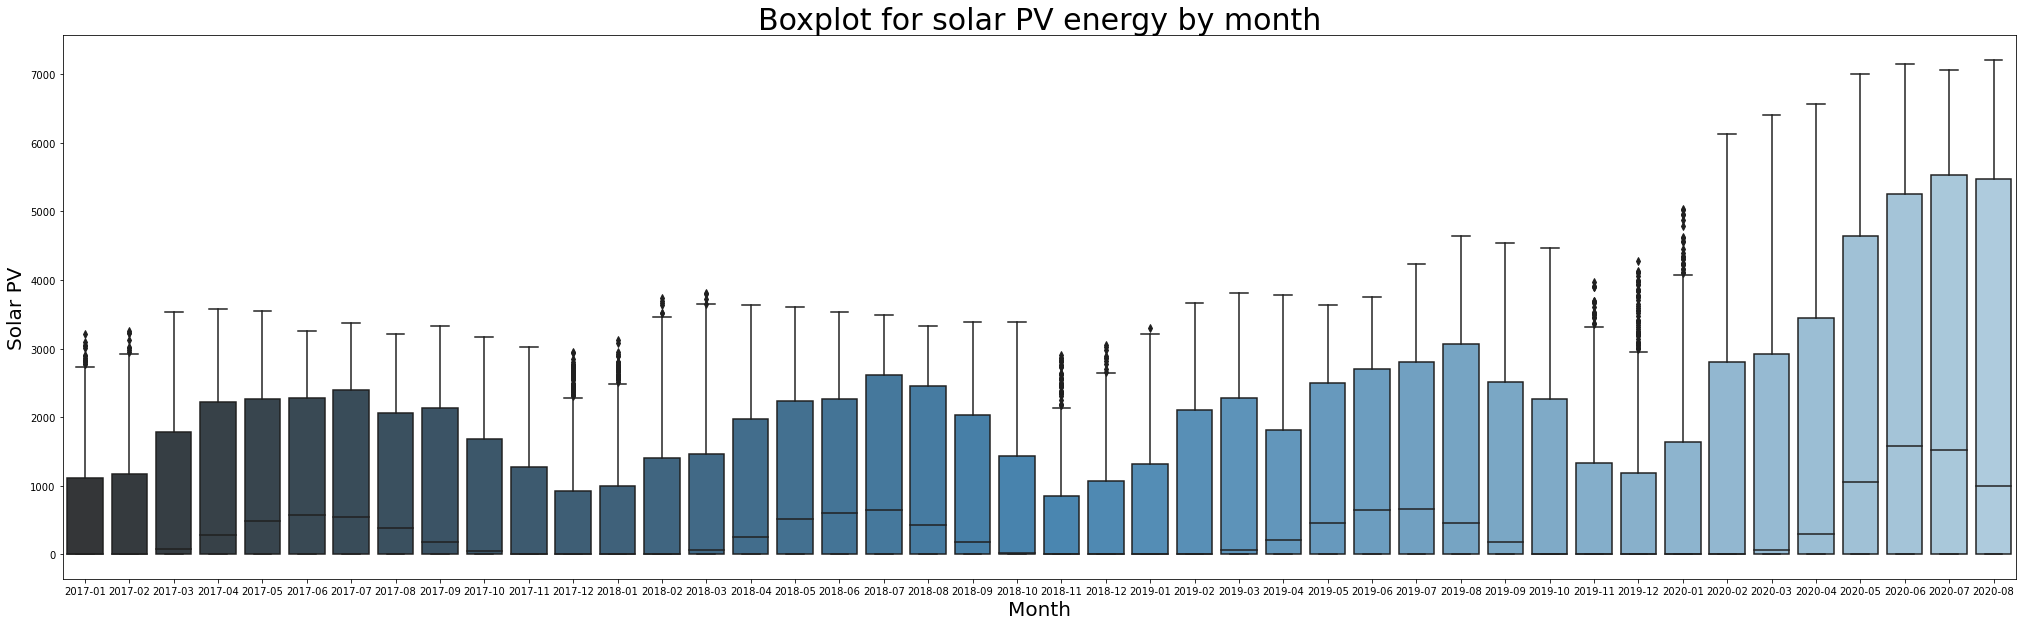

In [37]:
# Analyzing Energy Production by Year and by Month 
fig, (ax2) = plt.subplots(ncols=1, figsize=(35, 10))

sns.boxplot(x="year_month", y="fc_solar_pv", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for solar PV energy by month",fontsize = 30)
ax2.set_xlabel("Month" , fontsize = 20)
ax2.set_ylabel("Solar PV" , fontsize = 20)

Text(0, 0.5, 'Solar PV')

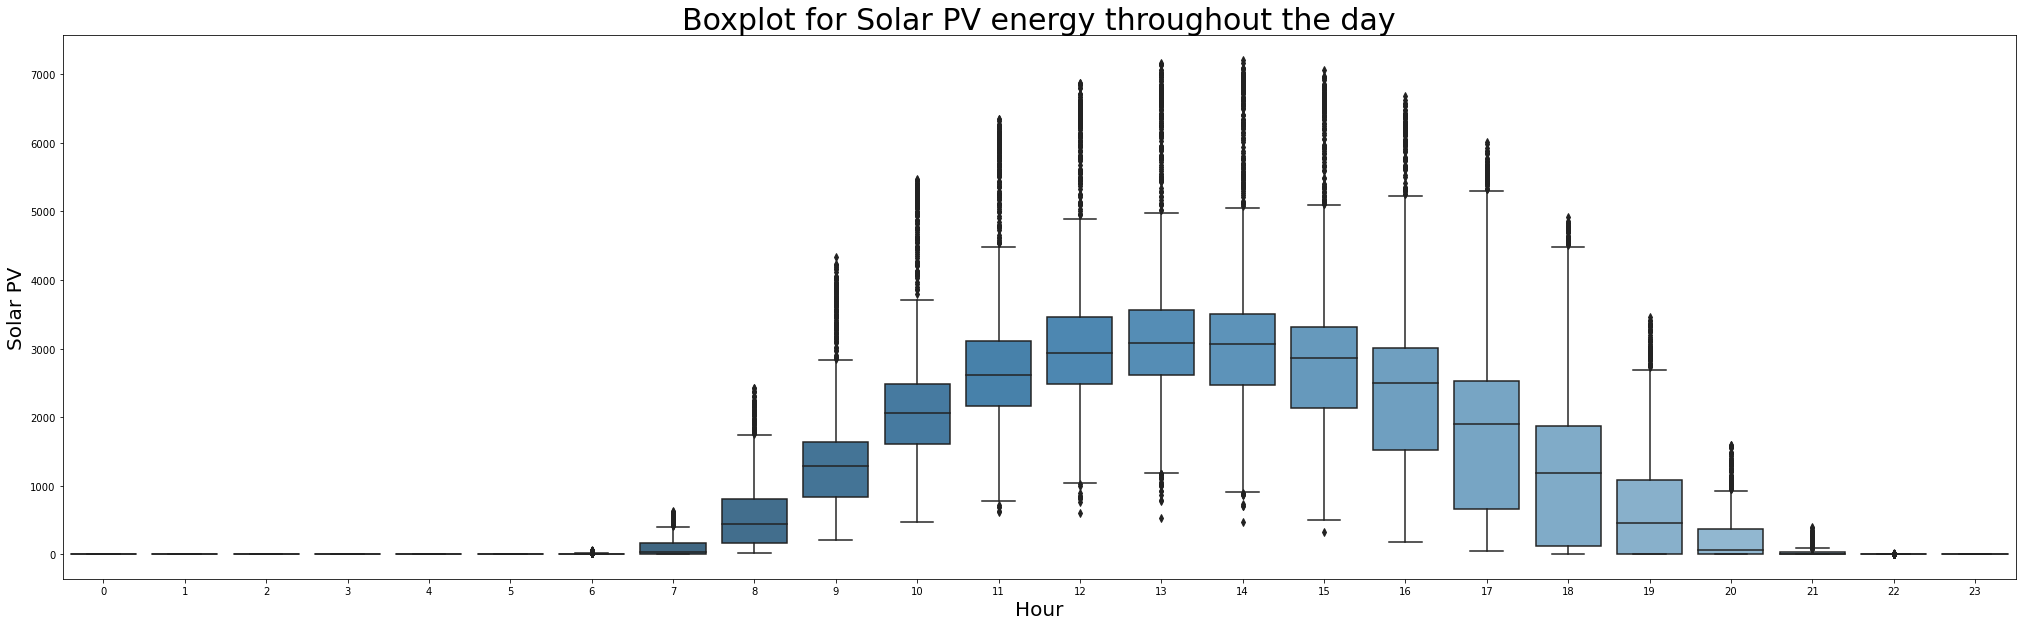

In [38]:
# Analyzing Energy Production throughout the day
fig, (ax2) = plt.subplots(ncols=1, figsize=(35, 10))

sns.boxplot(x="hour", y="fc_solar_pv", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for Solar PV energy throughout the day",fontsize = 30)
ax2.set_xlabel("Hour" , fontsize = 20)
ax2.set_ylabel("Solar PV" , fontsize = 20)

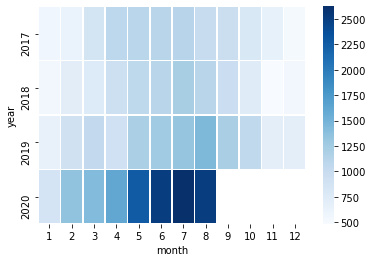

In [39]:
# How does energy production differ by month and year

data = df.groupby(["year","month"])["fc_solar_pv"].agg("mean").unstack().sort_index()
plt.figsize = (20,20)
sns.heatmap(data, cmap='Blues', linewidth=0.5);


In [40]:
# Check Outliers
col = "fc_solar_pv"
lowerbound,upperbound = get_borders(df[col]) # using above pre-defined function 
outliers = pd.DataFrame(df[(df[col] < lowerbound) | (df[col] > upperbound)][col])

# Print outliers
# outliers

# Get number of outliers
outliers.shape

(842, 1)

#### TH Solar

The production of Thermal Solar Power is also dependent on nature (sun/daylight), and as such undergoes daily and seasonal cycles. However, thermal solar systems produce heat and are therefore also running into the night hours with remaining heat from the day. As such, TH Solar Power is lowest during winter months (November to January) when the sun is much weaker and strongest during the summer months (May to September).

Text(0, 0.5, 'Solar TH')

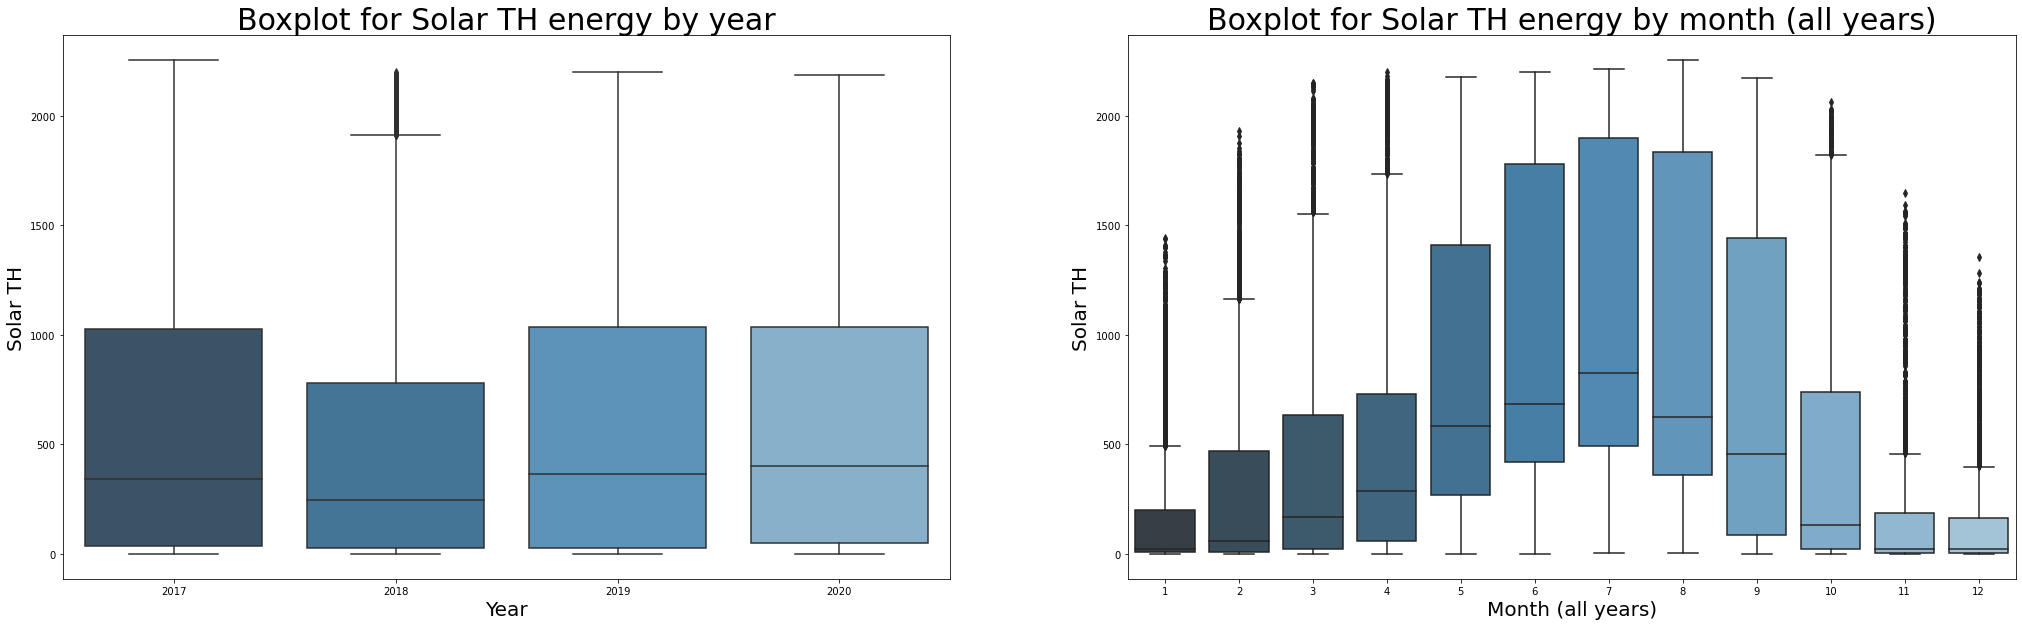

In [41]:
# Analyzing Energy Production by Year and by Month 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(35, 10))

sns.boxplot(x="year", y="fc_solar_th", data=df, ax=ax1, palette="Blues_d")
ax1.set_title("Boxplot for Solar TH energy by year",fontsize = 30)
ax1.set_xlabel("Year" , fontsize = 20)
ax1.set_ylabel("Solar TH" , fontsize = 20)

sns.boxplot(x="month", y="fc_solar_th", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for Solar TH energy by month (all years)",fontsize = 30)
ax2.set_xlabel("Month (all years)" , fontsize = 20)
ax2.set_ylabel("Solar TH" , fontsize = 20)

Text(0, 0.5, 'Solar TH')

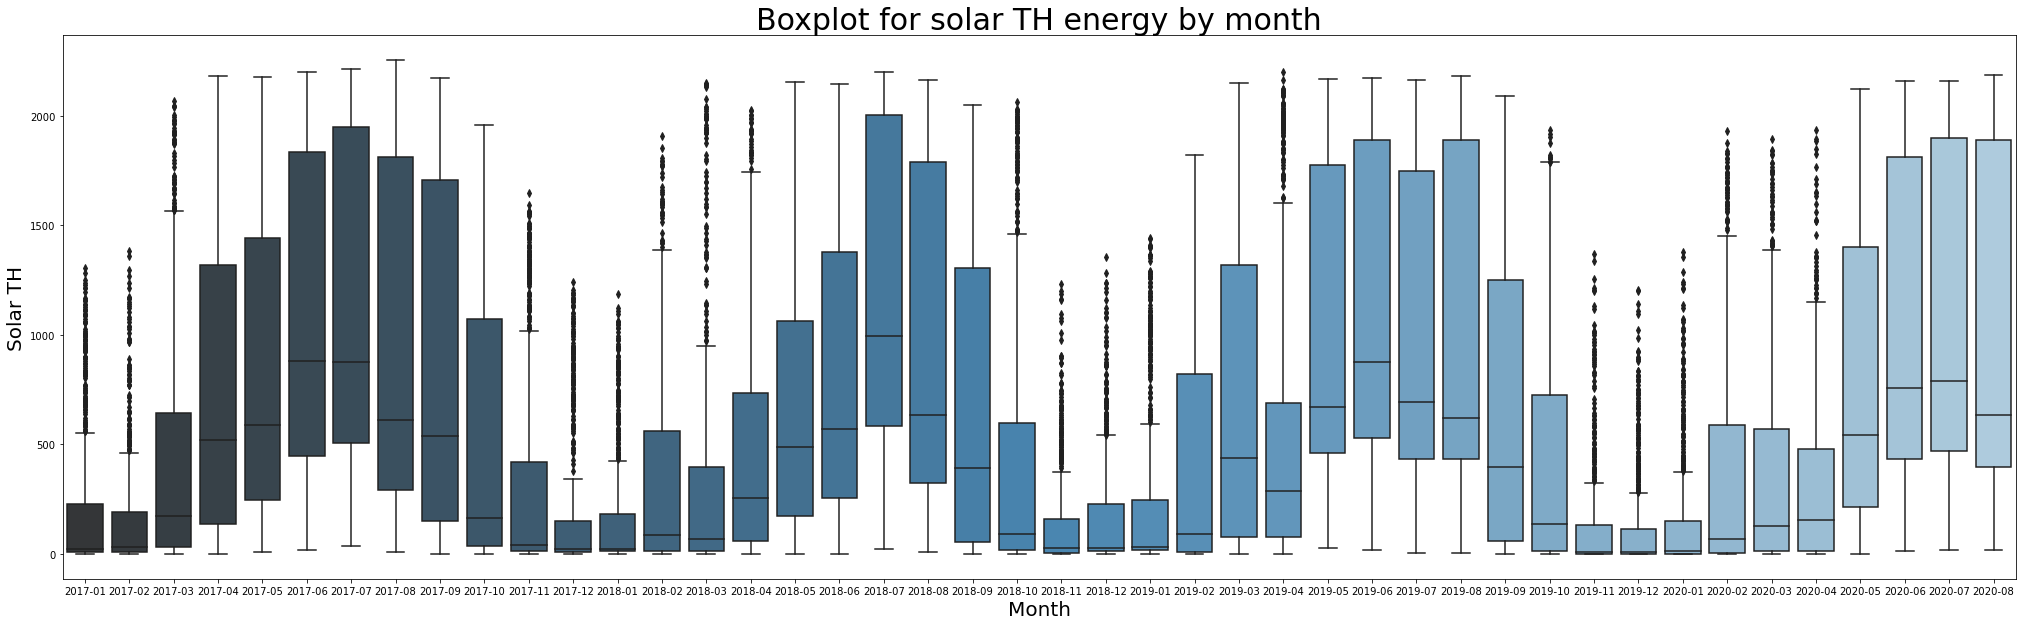

In [42]:
# Analyzing Energy Production by Year and by Month 
fig, (ax2) = plt.subplots(ncols=1, figsize=(35, 10))

sns.boxplot(x="year_month", y="fc_solar_th", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for solar TH energy by month",fontsize = 30)
ax2.set_xlabel("Month" , fontsize = 20)
ax2.set_ylabel("Solar TH" , fontsize = 20)

Text(0, 0.5, 'Solar TH')

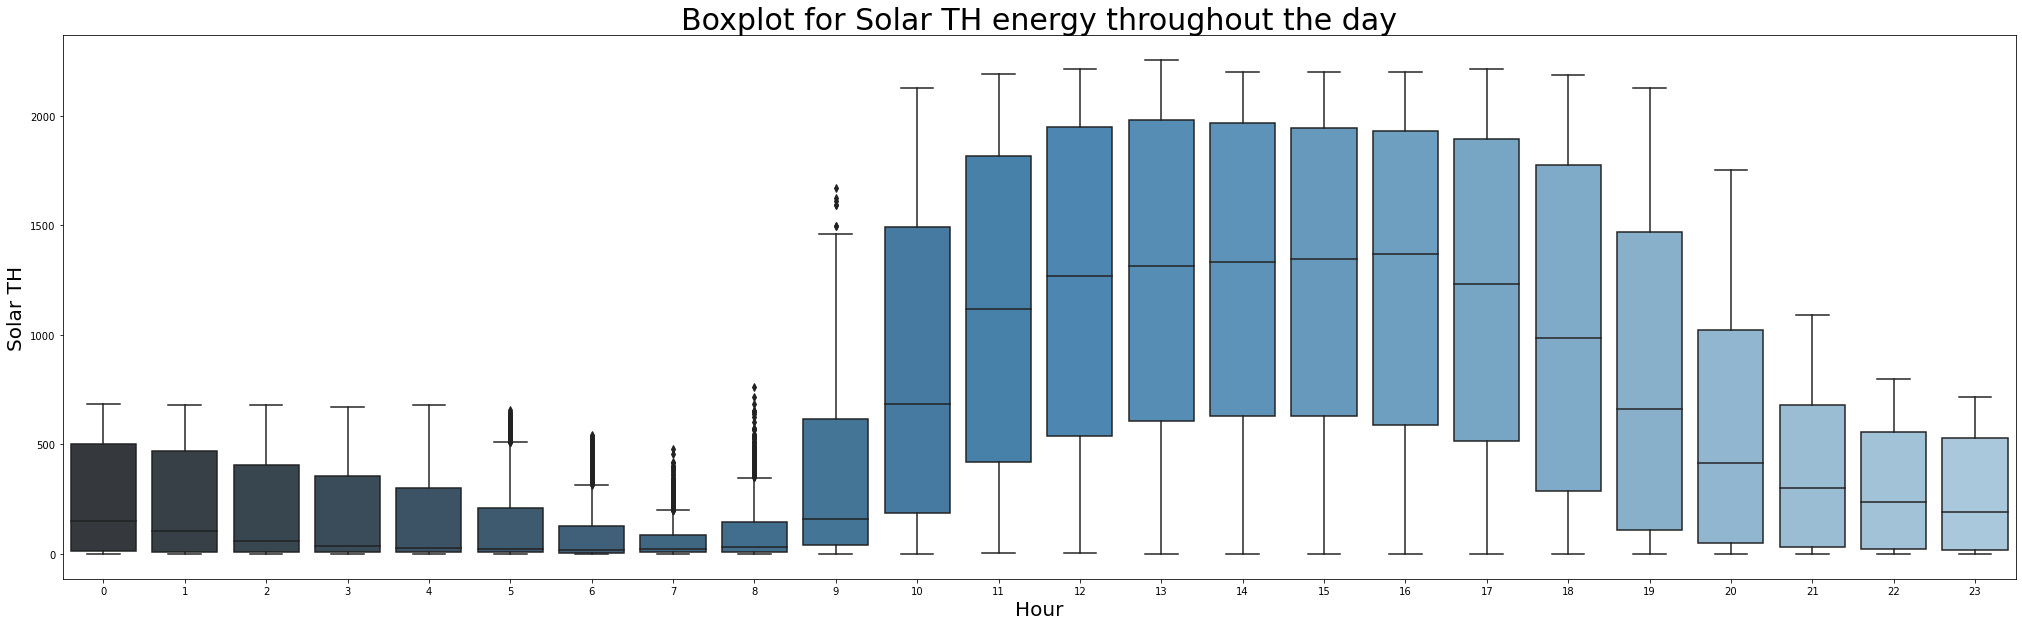

In [43]:
# Analyzing Energy Production throughout the day
fig, (ax2) = plt.subplots(ncols=1, figsize=(35, 10))

sns.boxplot(x="hour", y="fc_solar_th", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for Solar TH energy throughout the day",fontsize = 30)
ax2.set_xlabel("Hour" , fontsize = 20)
ax2.set_ylabel("Solar TH" , fontsize = 20)

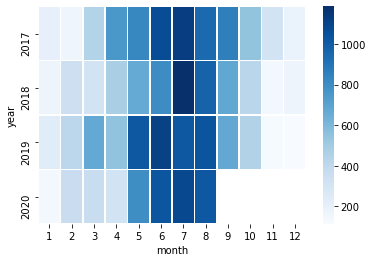

In [44]:
# How does energy production differ by month and year

     


In [45]:
# Check Outliers
col = "fc_solar_th"
lowerbound,upperbound = get_borders(df[col]) # using above pre-defined function 
outliers = pd.DataFrame(df[(df[col] < lowerbound) | (df[col] > upperbound)][col])

# Print outliers
# outliers

# Get number of outliers
outliers.shape

(0, 1)

#### Thermal Gap

In [46]:
# Defining Thermal gap
df['thermal_gap']=df['fc_demand']-(df['fc_nuclear']+df['fc_wind']+df['fc_solar_pv']+df['fc_solar_th'])

# Replace negative thermal gap with 0 since in that case demand is already covered by other energy sources
df['thermal_gap'] = np.where((df.thermal_gap <0),0,df.thermal_gap)


In [47]:
df['thermal_gap'].describe()

count   32135.000
mean    14726.046
std      5037.370
min         0.000
25%     11262.650
50%     14591.200
75%     18320.150
max     31155.400
Name: thermal_gap, dtype: float64

Text(0, 0.5, 'Thermal')

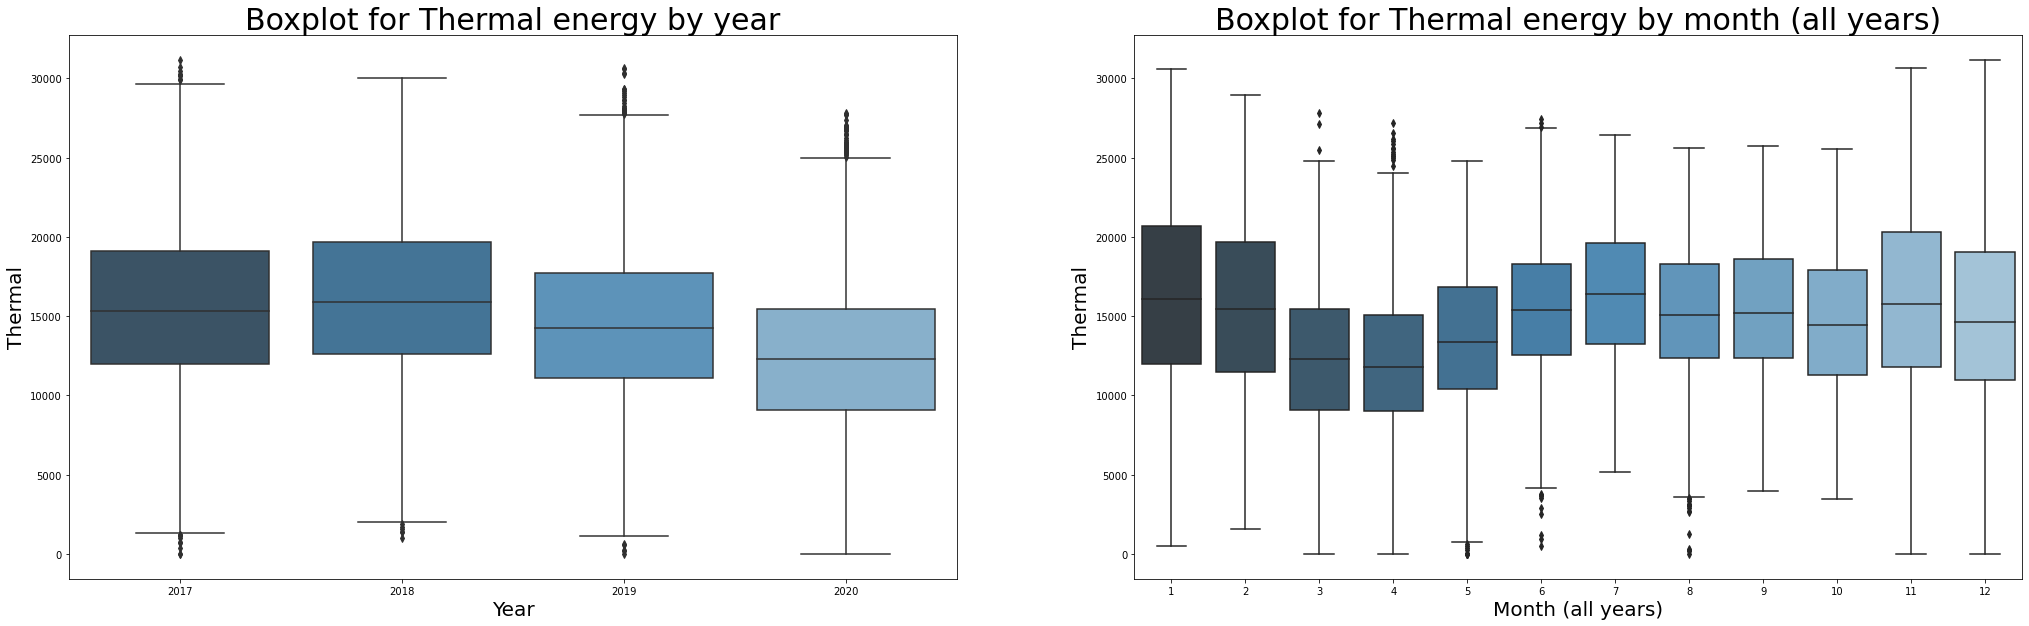

In [48]:
# Analyzing Energy Production by Year and by Month 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(35, 10))

sns.boxplot(x="year", y="thermal_gap", data=df, ax=ax1, palette="Blues_d")
ax1.set_title("Boxplot for Thermal energy by year",fontsize = 30)
ax1.set_xlabel("Year" , fontsize = 20)
ax1.set_ylabel("Thermal" , fontsize = 20)

sns.boxplot(x="month", y="thermal_gap", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for Thermal energy by month (all years)",fontsize = 30)
ax2.set_xlabel("Month (all years)" , fontsize = 20)
ax2.set_ylabel("Thermal" , fontsize = 20)

Text(0, 0.5, 'Thermal')

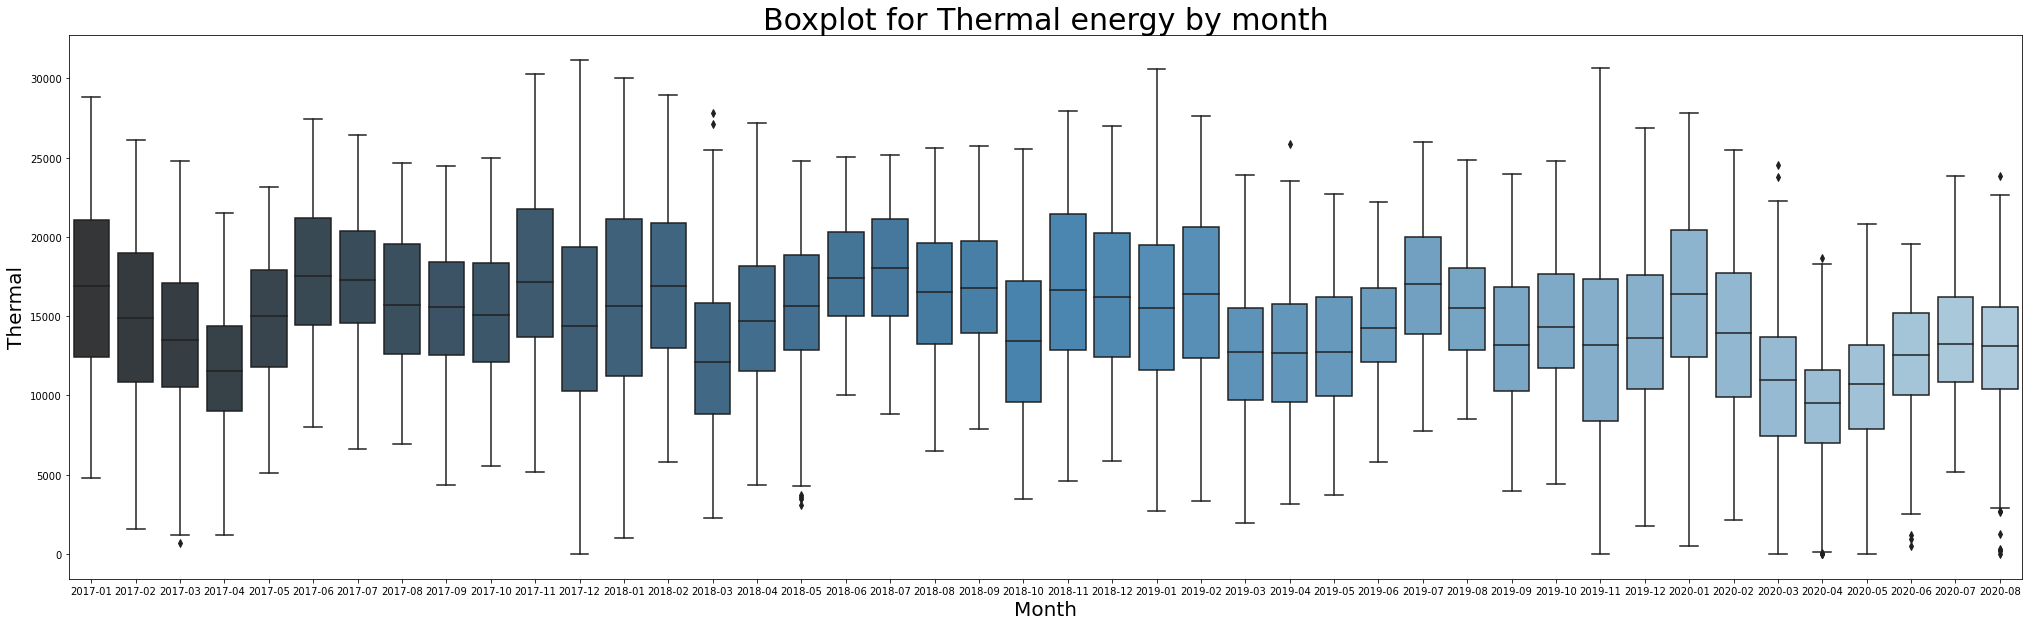

In [49]:
# Analyzing Energy Production by Year and by Month 
fig, (ax2) = plt.subplots(ncols=1, figsize=(35, 10))

sns.boxplot(x="year_month", y="thermal_gap", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for Thermal energy by month",fontsize = 30)
ax2.set_xlabel("Month" , fontsize = 20)
ax2.set_ylabel("Thermal" , fontsize = 20)

Text(0, 0.5, 'Thermal')

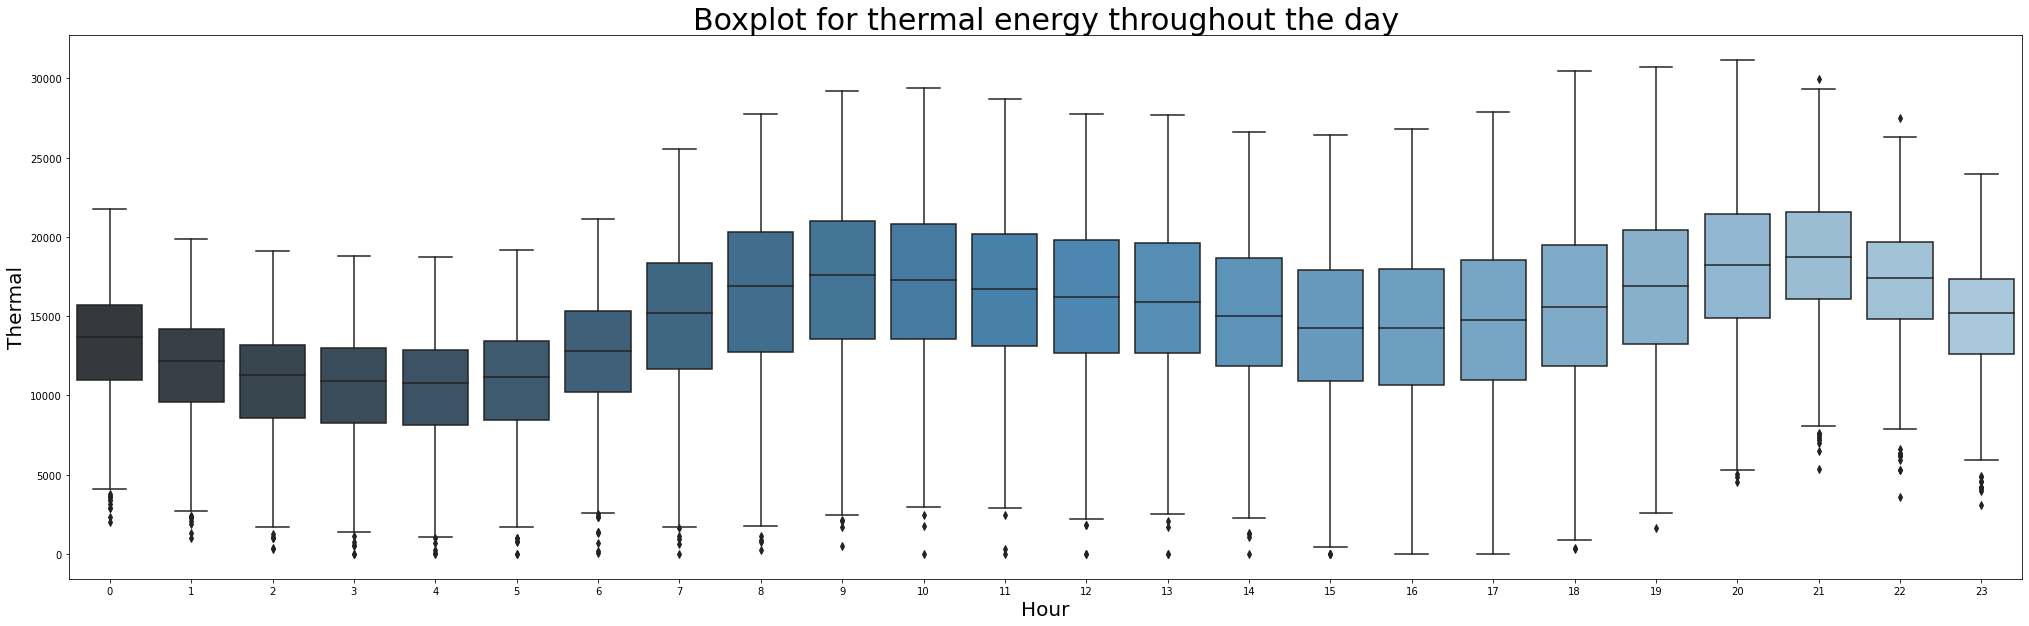

In [50]:
# Analyzing Energy Production throughout the day
fig, (ax2) = plt.subplots(ncols=1, figsize=(35, 10))

sns.boxplot(x="hour", y="thermal_gap", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for thermal energy throughout the day",fontsize = 30)
ax2.set_xlabel("Hour" , fontsize = 20)
ax2.set_ylabel("Thermal" , fontsize = 20)

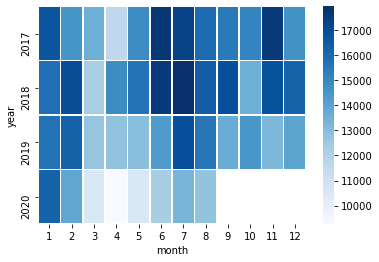

In [51]:
# How does energy production differ by month and year

data = df.groupby(["year","month"])["thermal_gap"].agg("mean").unstack().sort_index()
plt.figsize = (20,20)
sns.heatmap(data, cmap='Blues', linewidth=0.5);


In [52]:
# Check Outliers
col = "thermal_gap"
lowerbound,upperbound = get_borders(df[col]) # using above pre-defined function 
outliers = pd.DataFrame(df[(df[col] < lowerbound) | (df[col] > upperbound)][col])

# Print outliers
# outliers

# Get number of outliers
outliers.shape

(77, 1)

##### Energy mix

We dont observe any outliers for above variables with outliers+/- 3.0x IQR. 
With 1.5x IQR we observe the following outliers: 
- fc_nuclear: 728 outliers
- fc_wind: 347 outliers
- fc_solar_pv: 842 outliers
- fc_solar_th: 0 outliers

In [53]:
energy_mix = df[["year","fc_nuclear","fc_wind","fc_solar_pv","fc_solar_th","thermal_gap"]].groupby("year").agg("sum")
energy_mix["total"] = df["fc_nuclear"] + df["fc_wind"]+ df["fc_solar_pv"] + df["fc_solar_th"] + df["thermal_gap"]
energy_mix

fc_nuclear      fc_wind  fc_solar_pv  fc_solar_th   thermal_gap  \
year                                                                     
2017 57270138.400 47158051.000  7642719.200  5461654.600 135294026.000   
2018 54105572.000 48930267.000  7494757.100  4653746.800 139411786.100   
2019 57031239.900 52418677.000  9082486.100  5445555.900 126035478.900   
2020 37942599.500 32323549.000 11136685.300  3758174.100  72480189.900   

         total  
year            
2017 23571.000  
2018 21437.000  
2019 21160.000  
2020 21275.000

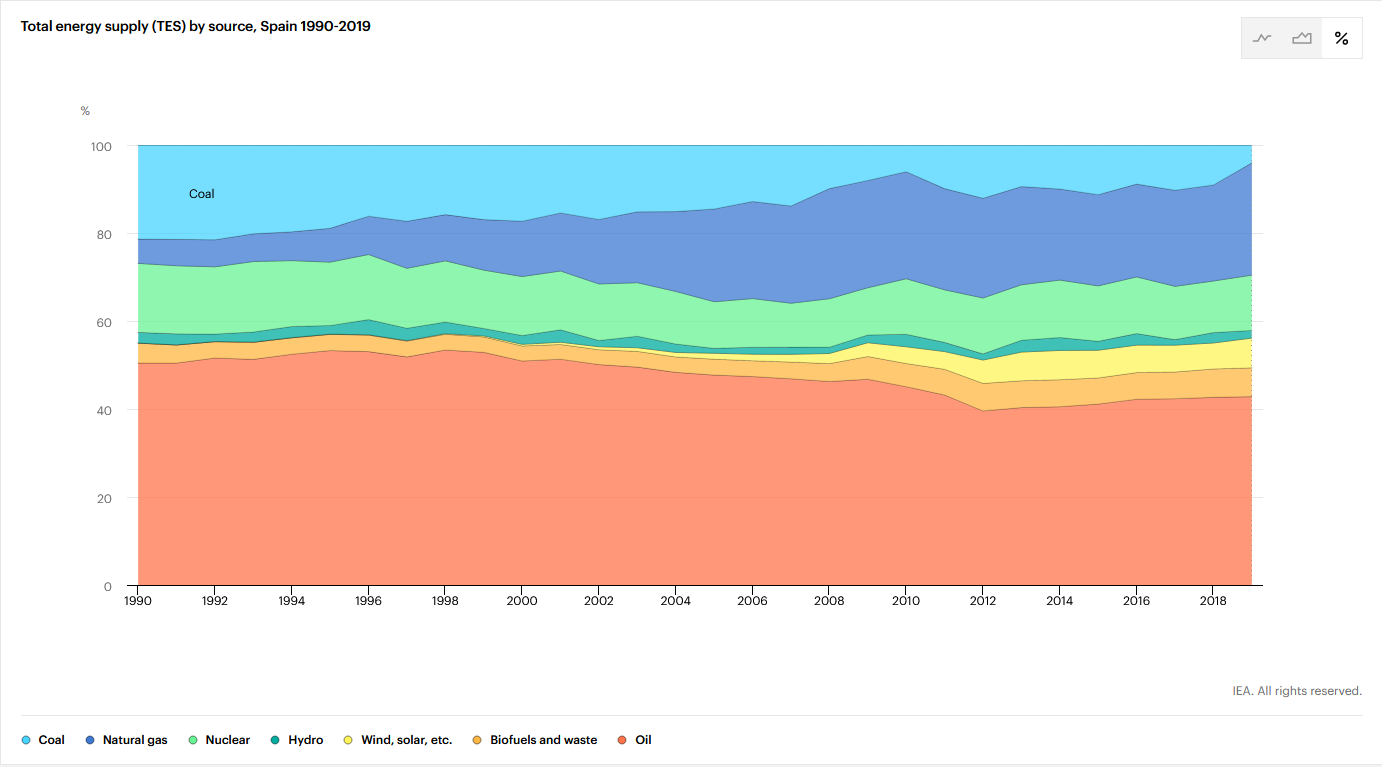
https://www.iea.org/countries/spain

We can test during the hyperparameter tuning, how to best deal wtih those outliers.

### Energy demand & import/export related data

In [54]:
# What we already know
df_info.loc[["fc_demand", "import_FR", "export_FR"]]

0  missing  unique  count       min       max      mean  \
fc_demand  float64        0   14956  32135 16372.000 41103.000 28475.594   
import_FR  float64       13      57  32122   700.000  3700.000  2445.285   
export_FR  float64       13      61  32122   200.000  3700.000  2217.865   

             median    stdev  
fc_demand 28446.000 4686.676  
import_FR  2450.000  623.215  
export_FR  2200.000  550.563

In [55]:
# Outliers

# Check for outliers
# "fc_demand", "import_FR", "export_FR"

col = "export_FR"
lowerbound,upperbound = get_borders(df[col]) # using above pre-defined function 
outliers = pd.DataFrame(df[(df[col] < lowerbound) | (df[col] > upperbound)][col])

# Print outliers
#outliers

# Get number of outliers
outliers.shape

(0, 1)

We dont observe any outliers for above variables with outliers+/- 3.0x IQR or +/- 1.5x IQR

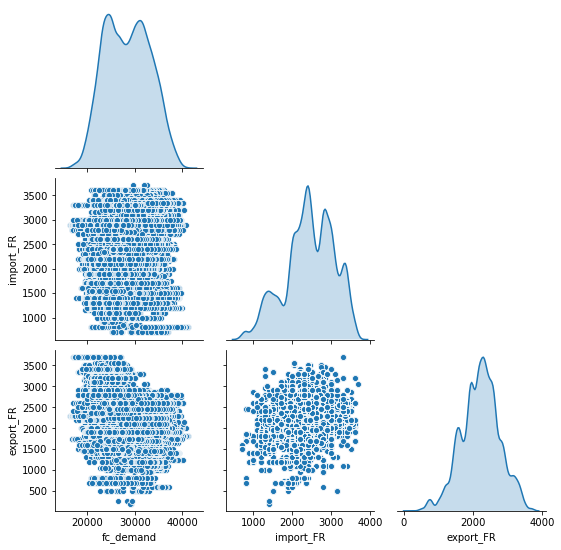

In [56]:
# Check Distributions
sns.pairplot(df[["fc_demand", "import_FR", "export_FR"]], diag_kind="kde", corner=True);

#### Demand

Text(0, 0.5, 'Demand')

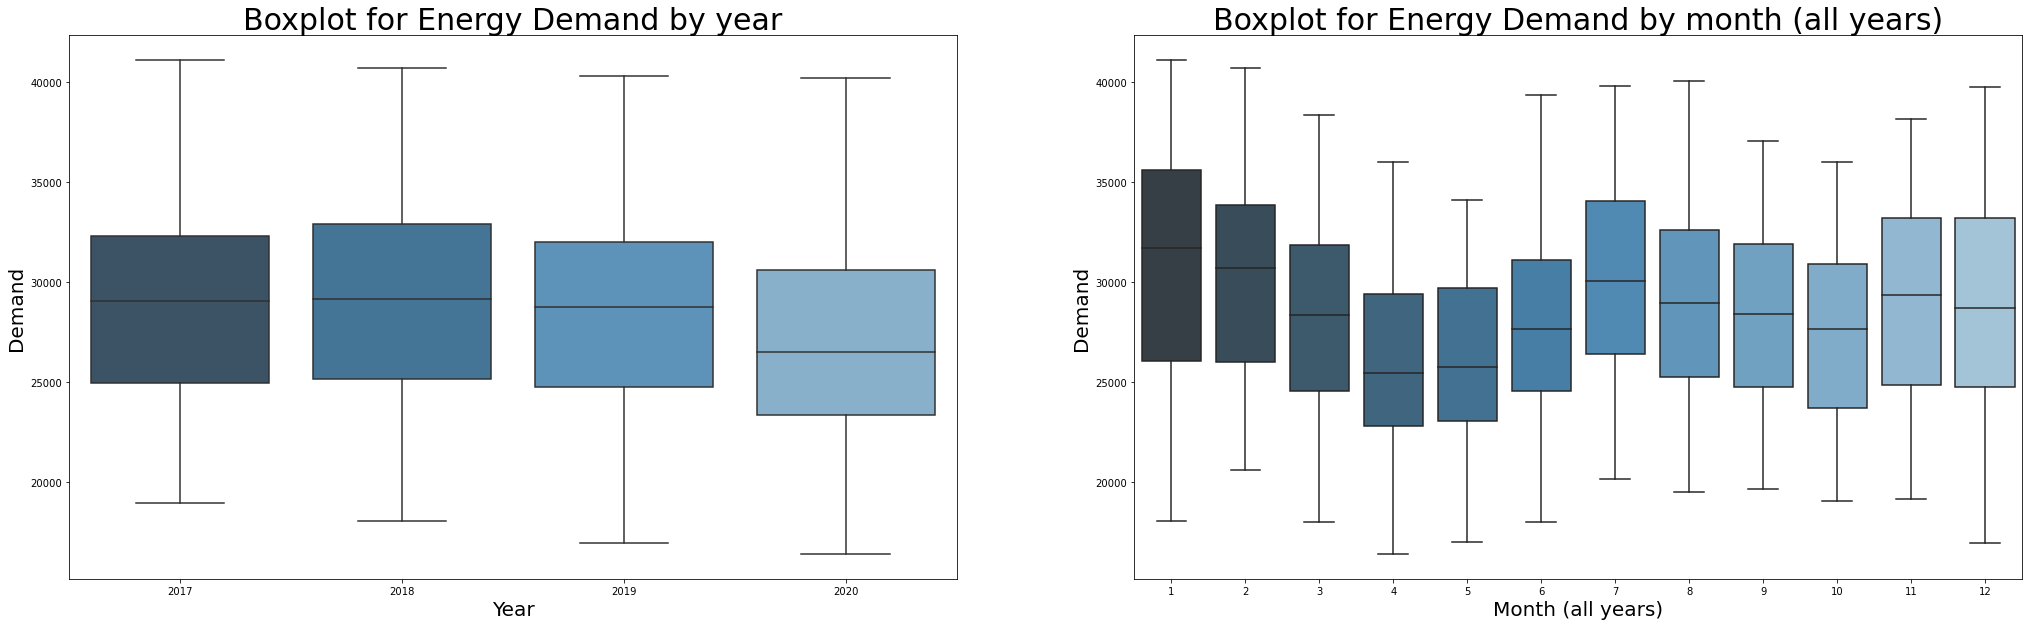

In [57]:
# Analyzing Energy Demand by Year and by Month 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(35, 10))

sns.boxplot(x="year", y="fc_demand", data=df, ax=ax1, palette="Blues_d")
ax1.set_title("Boxplot for Energy Demand by year",fontsize = 30)
ax1.set_xlabel("Year" , fontsize = 20)
ax1.set_ylabel("Demand" , fontsize = 20)

sns.boxplot(x="month", y="fc_demand", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for Energy Demand by month (all years)",fontsize = 30)
ax2.set_xlabel("Month (all years)" , fontsize = 20)
ax2.set_ylabel("Demand" , fontsize = 20)

Text(0, 0.5, 'Demand')

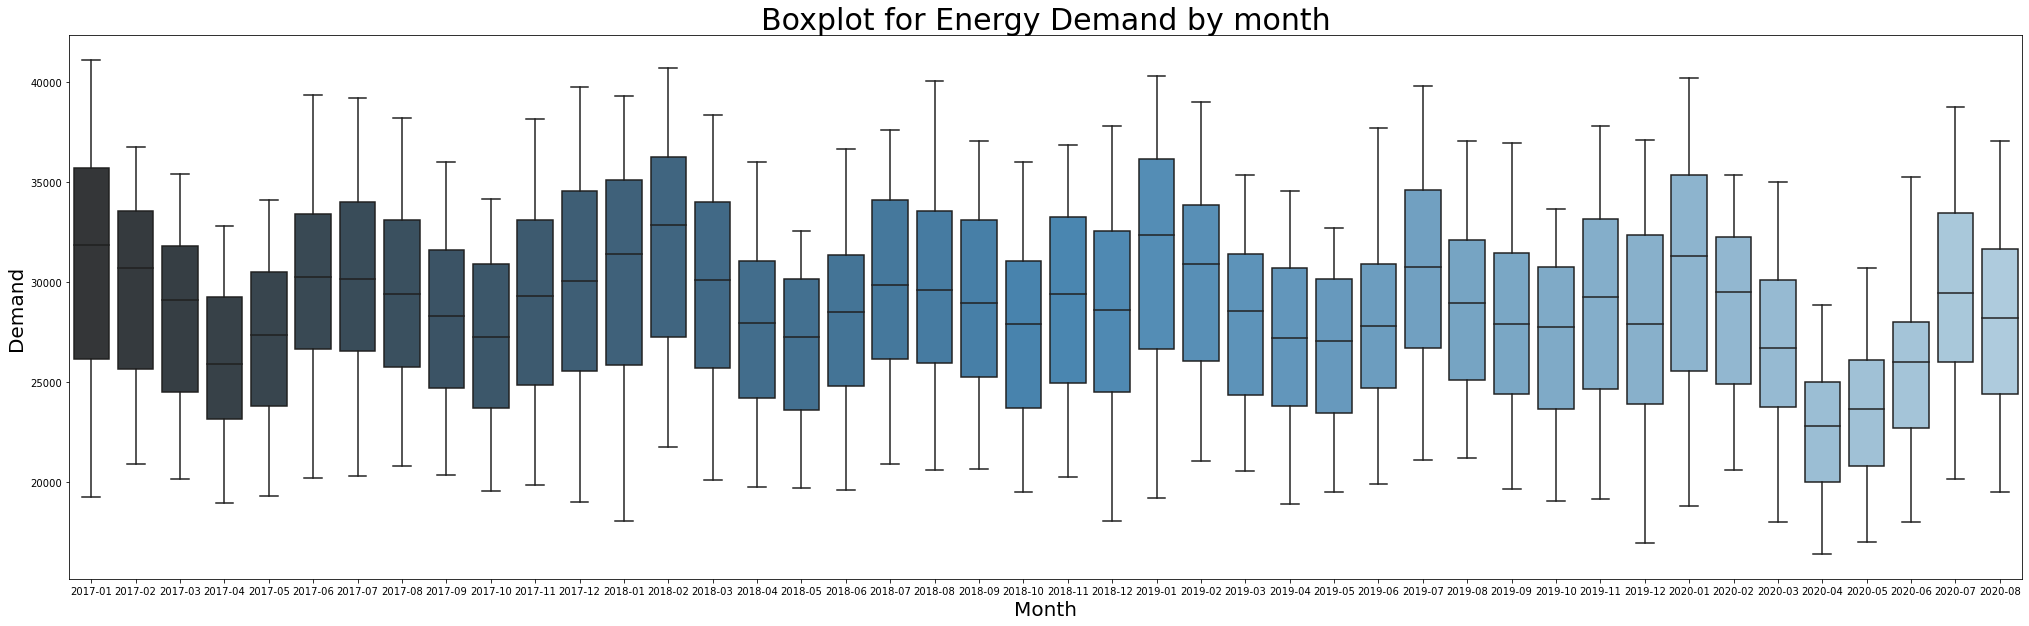

In [58]:
# Analyzing Energy Demand by Year and by Month 
fig, (ax2) = plt.subplots(ncols=1, figsize=(35, 10))

sns.boxplot(x="year_month", y="fc_demand", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for Energy Demand by month",fontsize = 30)
ax2.set_xlabel("Month" , fontsize = 20)
ax2.set_ylabel("Demand" , fontsize = 20)

Text(0, 0.5, 'Demand')

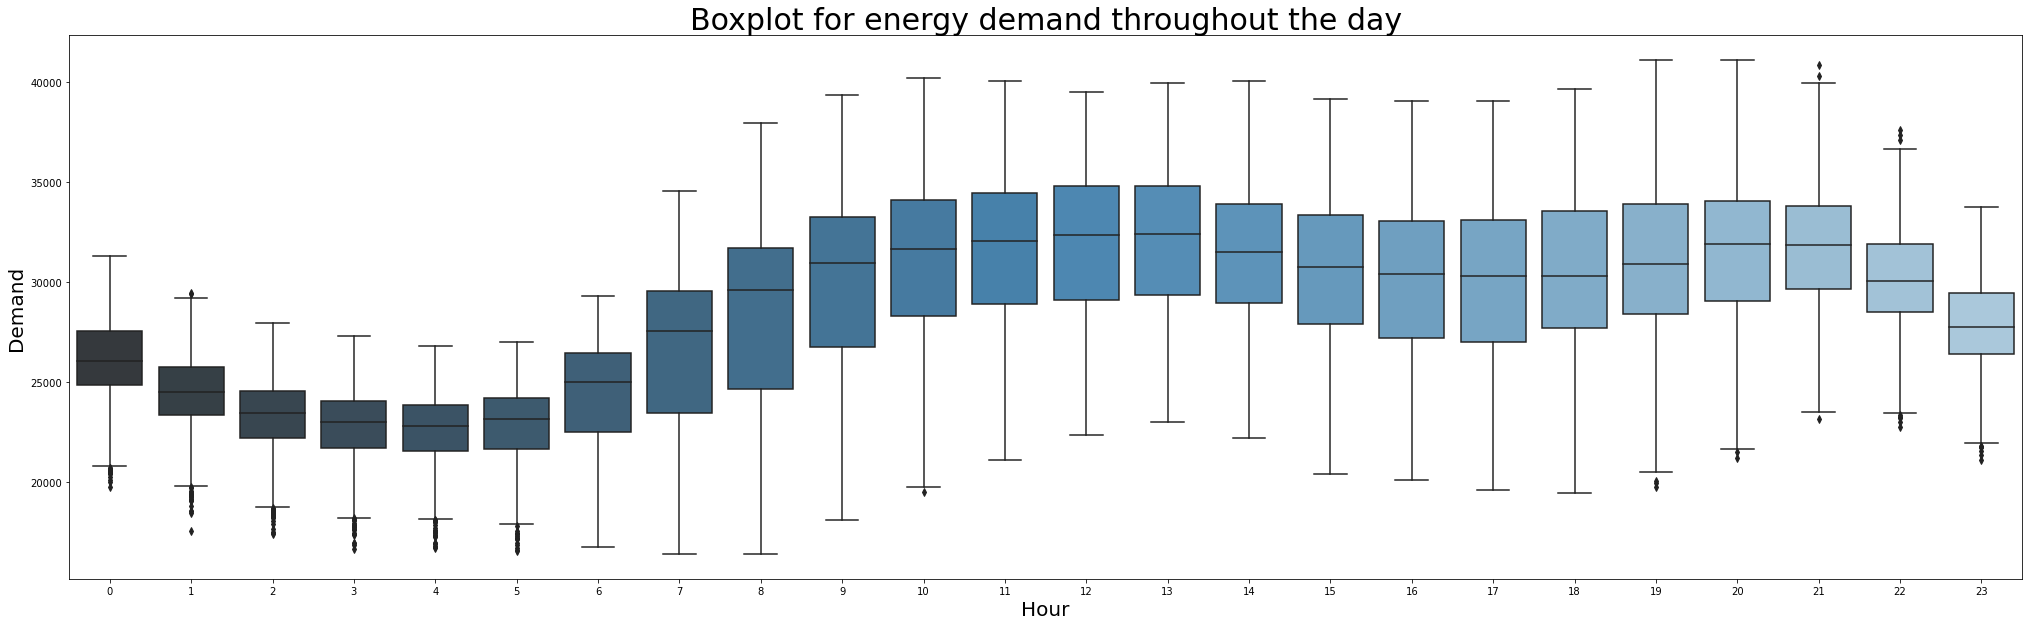

In [59]:
# Analyzing Energy Demand throughout the day
fig, (ax2) = plt.subplots(ncols=1, figsize=(35, 10))

sns.boxplot(x="hour", y="fc_demand", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for energy demand throughout the day",fontsize = 30)
ax2.set_xlabel("Hour" , fontsize = 20)
ax2.set_ylabel("Demand" , fontsize = 20)

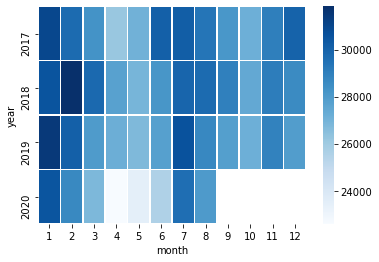

In [60]:
# How does energy demand differ by month and year

data = df.groupby(["year","month"])["fc_demand"].agg("mean").unstack().sort_index()
plt.figsize = (20,20)
sns.heatmap(data, cmap='Blues', linewidth=0.5);


#### Price Data

In [61]:
# What we already know
df_info.loc[["price"]]

0  missing  unique  count   min     max   mean  median  stdev
price  float64        0    5871  32135 0.030 101.990 48.440  49.880 14.842

In [62]:
# Outliers

# Check for outliers

col = "price"
lowerbound,upperbound = get_borders(df[col]) # using above pre-defined function 
outliers = pd.DataFrame(df[(df[col] < lowerbound) | (df[col] > upperbound)][col])

# Print outliers
# outliers

# Get number of outliers
outliers.shape

(690, 1)

Text(0, 0.5, 'Price')

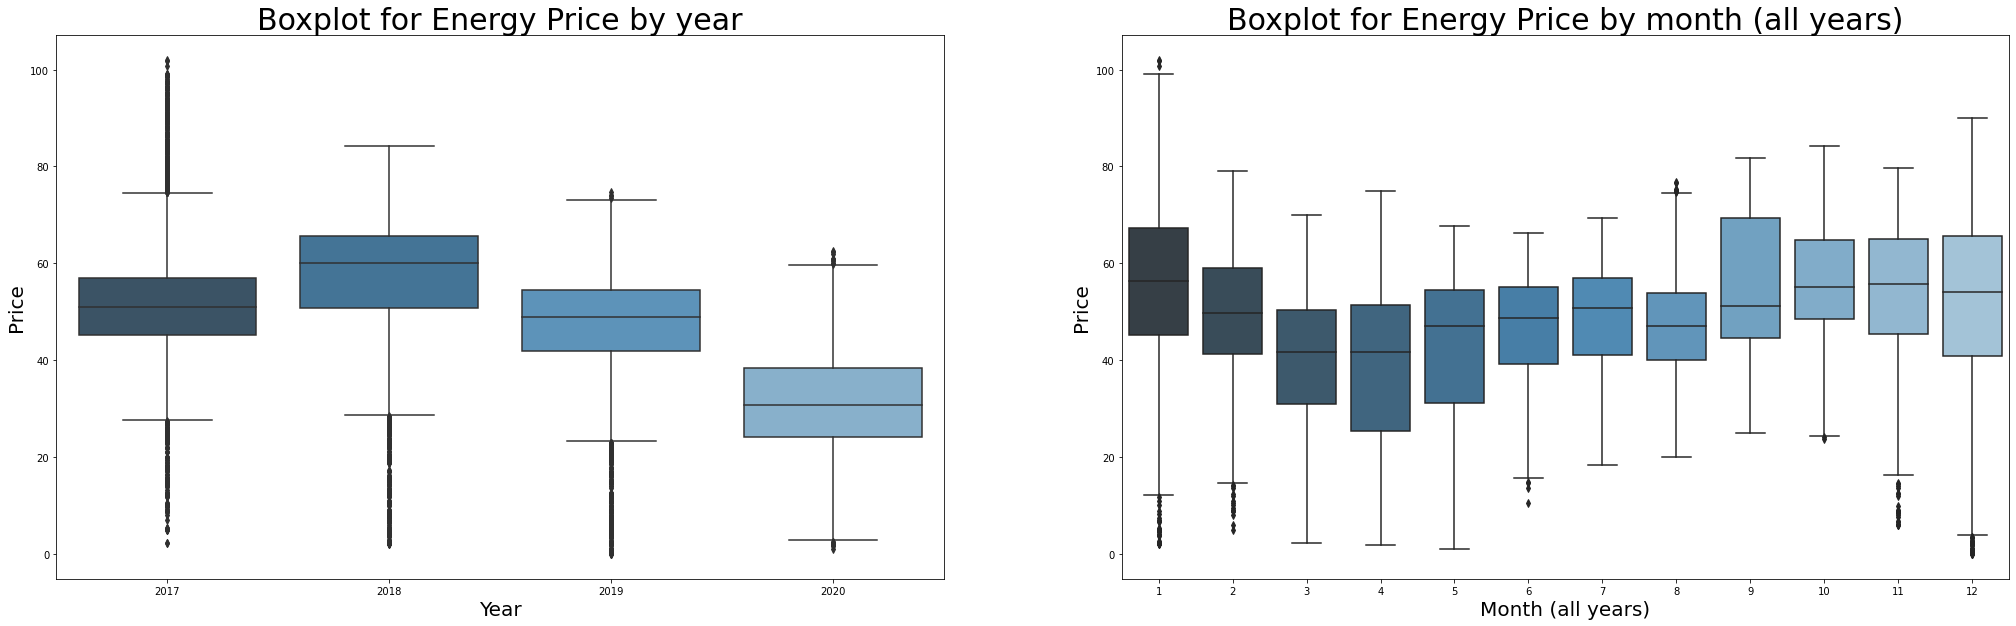

In [63]:
# Analyzing Energy Price by Year and by Month 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(35, 10))

sns.boxplot(x="year", y="price", data=df, ax=ax1, palette="Blues_d")
ax1.set_title("Boxplot for Energy Price by year",fontsize = 30)
ax1.set_xlabel("Year" , fontsize = 20)
ax1.set_ylabel("Price" , fontsize = 20)

sns.boxplot(x="month", y="price", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for Energy Price by month (all years)",fontsize = 30)
ax2.set_xlabel("Month (all years)" , fontsize = 20)
ax2.set_ylabel("Price" , fontsize = 20)

Text(0, 0.5, 'Price')

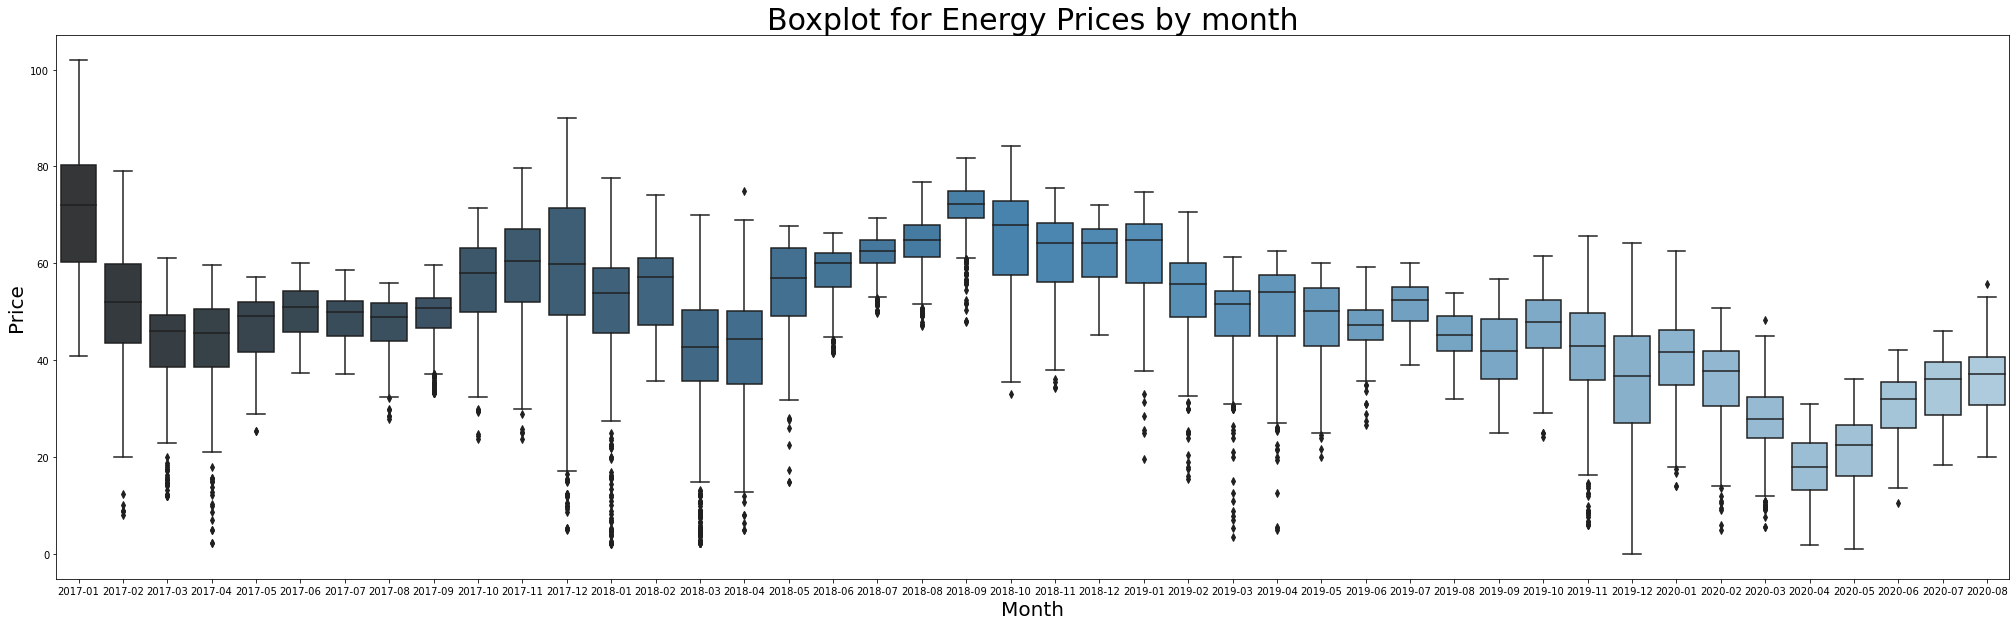

In [64]:
# Analyzing Energy Demand by Year and by Month 
fig, (ax2) = plt.subplots(ncols=1, figsize=(35, 10))

sns.boxplot(x="year_month", y="price", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for Energy Prices by month",fontsize = 30)
ax2.set_xlabel("Month" , fontsize = 20)
ax2.set_ylabel("Price" , fontsize = 20)

Text(0, 0.5, 'Price')

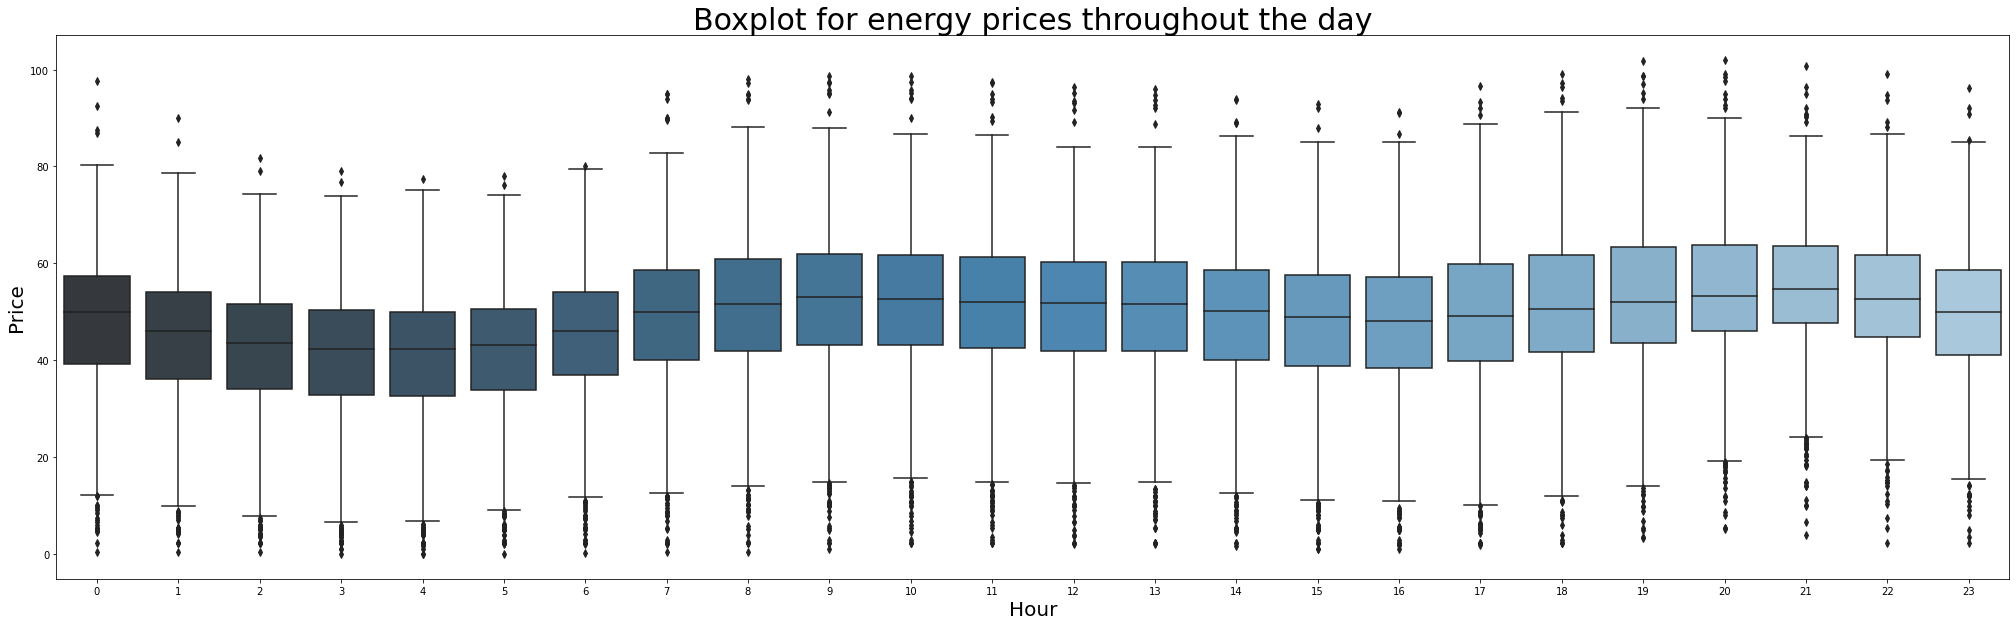

In [65]:
# Analyzing Energy Prices throughout the day
fig, (ax2) = plt.subplots(ncols=1, figsize=(35, 10))

sns.boxplot(x="hour", y="price", data=df, ax=ax2, palette="Blues_d")
ax2.set_title("Boxplot for energy prices throughout the day",fontsize = 30)
ax2.set_xlabel("Hour" , fontsize = 20)
ax2.set_ylabel("Price" , fontsize = 20)

##### Correlation of energy prices and sources

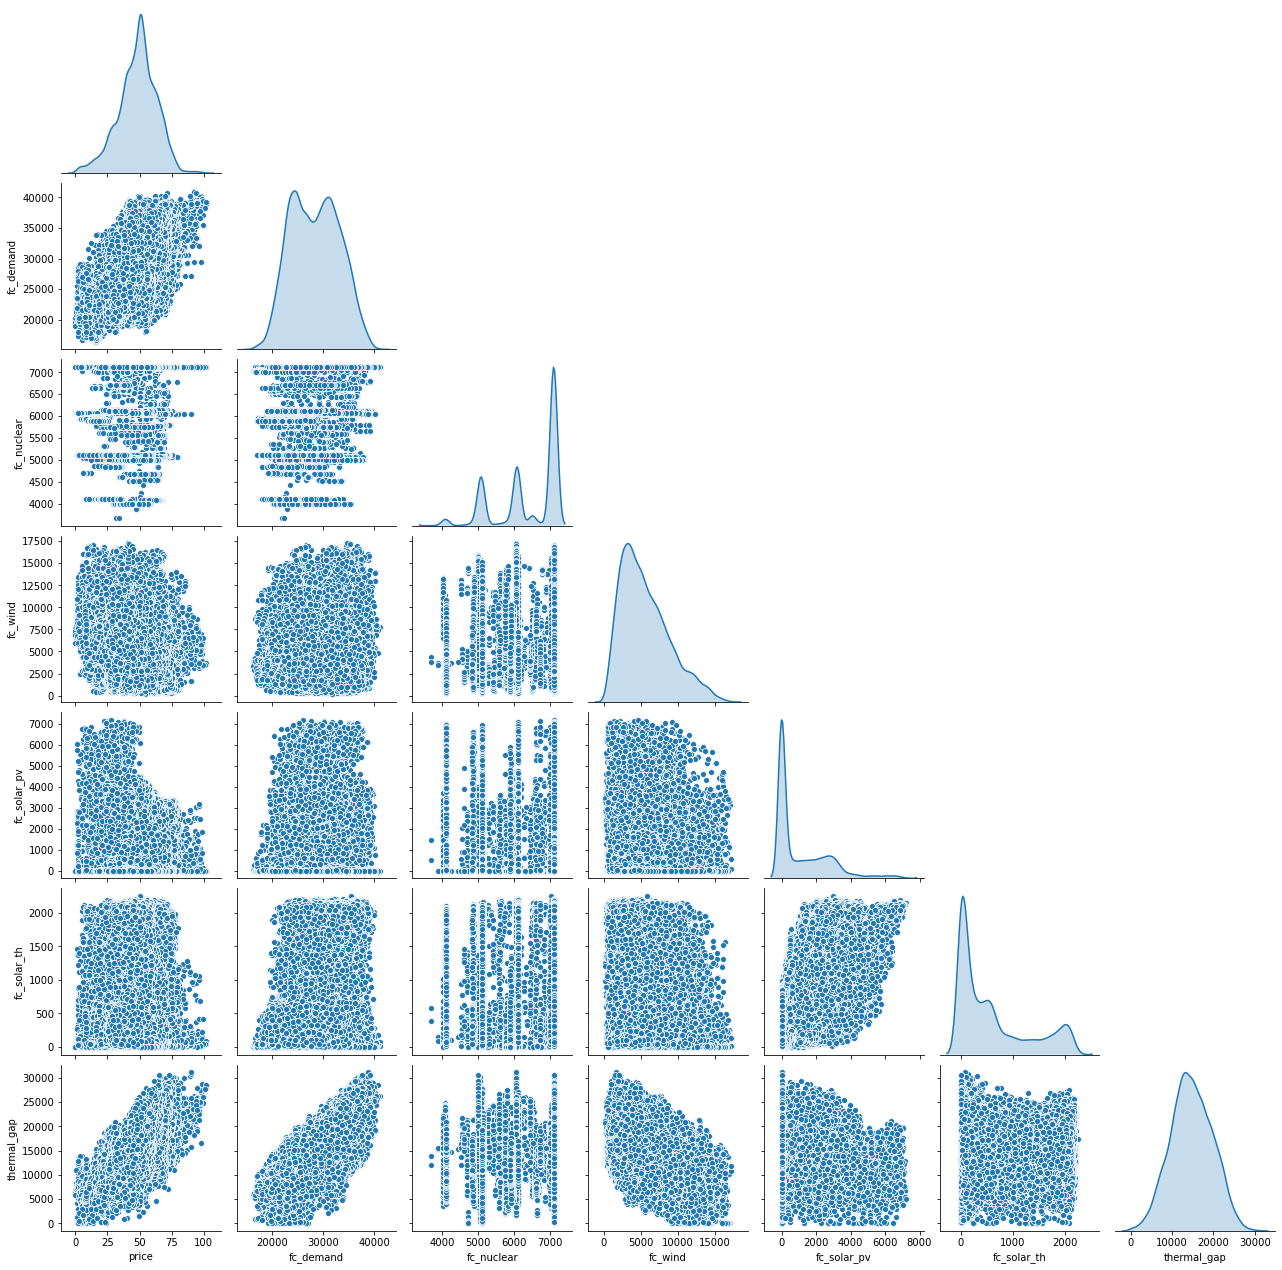

In [66]:
# Check Distributions
sns.pairplot(df[["price","fc_demand", "fc_nuclear", "fc_wind","fc_solar_pv","fc_solar_th","thermal_gap"]], diag_kind="kde", corner=True);

We can visually observe a correlation between energy prices and the forecasted thermal gap as well as between prices and forecasted demand. Both observations make sense since (a) for commodities prices usually are driven by demand, and (b) thermal energy is a key component in the energy mix and considered as "expensive production".

##### Autocorrelation of energy prices

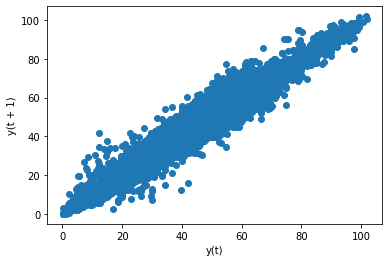

In [67]:
from matplotlib import pyplot
from pandas.plotting import lag_plot
lag_plot(df["price"])
pyplot.show()

In [68]:
price_lag = pd.concat([df["price"].shift(1), df["price"]], axis=1)
price_lag.columns = ["t-1","t"]
result = price_lag.corr()
print(result)

      t-1     t
t-1 1.000 0.979
t   0.979 1.000


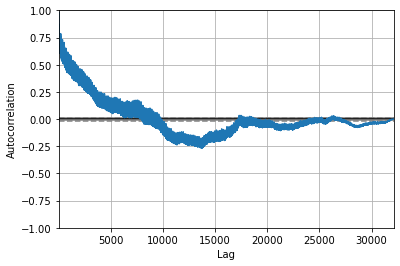

In [69]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df["price"])

#### Other

In [70]:
corr = df.corr() # Calculates correlation matrix
corr.style.background_gradient(cmap='coolwarm') # This line plots nicely visualized matrix of correlation

In [71]:
# Create a checkin to save progress
df_eda = df.copy()

# 3. Preparing the Data

### 3.1 Basic Transformations

#### Impute missing values

In [72]:
#Impute null values

from sklearn.impute import SimpleImputer,KNNImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')

miss_values = ["import_FR","export_FR"]

for col in miss_values: 
    imp = imp.fit(df[[col]])
    df[col] = imp.transform(df[[col]]).ravel()

In [73]:
# Check that no more null values
df.isna().sum()

fc_demand      0
fc_nuclear     0
import_FR      0
export_FR      0
fc_wind        0
fc_solar_pv    0
fc_solar_th    0
price          0
date           0
hour           0
year           0
month          0
day_of_week    0
year_month     0
thermal_gap    0
dtype: int64

#### Change Datatypes

In [74]:
df.dtypes

fc_demand             float64
fc_nuclear            float64
import_FR             float64
export_FR             float64
fc_wind               float64
fc_solar_pv           float64
fc_solar_th           float64
price                 float64
date           datetime64[ns]
hour                    int64
year                    int64
month                   int64
day_of_week             int64
year_month          period[M]
thermal_gap           float64
dtype: object

In [75]:
# Change to integer format

col_list = ['fc_demand', 'import_FR', 'export_FR', 'fc_wind']

for col in col_list:
    df[col] = df[col].astype(np.int64)

#### Remove Outliers

In [76]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25) 
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out

In [77]:
df = remove_outlier(df,'fc_wind')

347 outliers removed


In [78]:
df = remove_outlier(df,'fc_solar_pv')

840 outliers removed


In [79]:
df = remove_outlier(df,'fc_nuclear')

622 outliers removed


In [80]:
df = df.drop(columns=["year_month"], axis=1)

In [81]:
# Create a checkin to save progress
df_baseline = df.copy()

# 4. Exploring and shortlisting Basic Models 

## 4.1 Define Error Measures

In [82]:
# Set up Cross-Validation to check for stable split/results
from sklearn.model_selection import cross_validate

# Define a function to get cross-validation scores
cross_validation = {}

def get_scores(scores, name):
    #print("Scores:",scores)
    scores_dict = {}
    scores_dict["Cross Validation"] = name
    scores_dict["RMSE Scores"] = scores.round(2)
    scores_dict["Mean RMSE"] = scores.mean().round(4)
    scores_dict["StDev RMSE"] = scores.std().round(4)
    return scores_dict

# Show scores only 
def display_scores(scores):
    print("Scores:",scores.round(4))
    print("Mean:",scores.mean().round(4))
    print("St.Dev:", scores.std().round(4))

## 4.2 Prepare Data

### Decide on variables for training

### Scale variables

Since most algorithms require input features of a similar scale, we will also perform feature Scaling.

In [83]:
columns_to_scale = df_baseline.columns[(df_baseline.dtypes!='datetime64') | (df_baseline.dtypes!='object') | (df_baseline.dtypes!='int32')].tolist()
columns_to_scale.remove("price")
columns_to_scale.remove("date")
#columns_to_scale.remove("year")
#columns_to_scale.remove("month")
#columns_to_scale.remove("hour")
#columns_to_scale.remove("day_of_week")
#columns_to_scale.remove("price")
columns_to_scale

['fc_demand',
 'fc_nuclear',
 'import_FR',
 'export_FR',
 'fc_wind',
 'fc_solar_pv',
 'fc_solar_th',
 'hour',
 'year',
 'month',
 'day_of_week',
 'thermal_gap']

In [84]:
# Define Scaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler

StandardScaler
stsc = StandardScaler()

#Standardize df_scaled
for col in columns_to_scale:
    standardscaler = stsc.fit(df_baseline[[col]])
    df_baseline[col] = standardscaler.transform(df_baseline[[col]])
    
# RobustScaler
# rsc = RobustScaler()

In [85]:
df_baseline.describe()

fc_demand  fc_nuclear  import_FR  export_FR   fc_wind  fc_solar_pv  \
count  30326.000   30326.000  30326.000  30326.000 30326.000    30326.000   
mean      -0.000       0.000     -0.000     -0.000    -0.000       -0.000   
std        1.000       1.000      1.000      1.000     1.000        1.000   
min       -2.574      -2.474     -2.782     -3.658    -1.740       -0.751   
25%       -0.827      -0.508     -0.556     -0.588    -0.786       -0.751   
50%       -0.011       0.812      0.080      0.044    -0.180       -0.697   
75%        0.777       0.812      0.716      0.676     0.635        0.759   
max        2.697       0.812      1.988      2.662     2.825        3.347   

       fc_solar_th     price      hour      year     month  day_of_week  \
count    30326.000 30326.000 30326.000 30326.000 30326.000    30326.000   
mean        -0.000    49.202     0.000     0.000     0.000        0.000   
std          1.000    14.528     1.000     1.000     1.000        1.000   
min         -0.866     0.030    -1.632    -1.245    -1.518       -1.497   
25%         -0.821    40.850    -0.918    -1.245    -0.930       -0.998   
50%         -0.397    50.190    -0.061    -0.288    -0.048        0.000   
75%          0.457    58.700     0.939     0.670     0.835        0.998   
max          2.550   101.990     1.654     1.627     1.717        1.497   

       thermal_gap  
count    30326.000  
mean         0.000  
std          1.000  
min         -2.977  
25%         -0.691  
50%         -0.031  
75%          0.718  
max          3.261

In [86]:
df_baseline.dtypes

fc_demand             float64
fc_nuclear            float64
import_FR             float64
export_FR             float64
fc_wind               float64
fc_solar_pv           float64
fc_solar_th           float64
price                 float64
date           datetime64[ns]
hour                  float64
year                  float64
month                 float64
day_of_week           float64
thermal_gap           float64
dtype: object

## 4.3 Define Date Split

We will be using cross-validation to find the best models for predicion. Given that, we will not split our training set into a test and training data but use the entire data set with cross-validation. The overall model performance will then be evaluated on the scoring set (which acts us our test-set). 

For the cross-validation, we will use scikit built-in time-split method. When working with time series data, we cannot just split the dataset randomly into a validation and training set but instead we need to split it according to dates.

In [87]:
# Check start and end date -> We have 1339 days
df_baseline["date"].apply(["min","max"])

min   2017-01-01
max   2020-08-31
Name: date, dtype: datetime64[ns]

In [88]:
df_baseline = df_baseline.drop(columns=["year"], axis=1)

In [89]:
# Define a function to cut the training set

def train_test_split(data, date_split):
    
    # Delete all rows before this date
    df_model = df_train_test[df_train_test["date"] > date_start]

    # training vs target
    x = df_model.drop(["price"], axis=1) # dropping price since this will be our dependent variable
    y = df_model[["date", "price"]]

    # splitting data
    x_train = x[x["date"] < date_split].drop("date", axis=1)
    x_test = x[x["date"] >= date_split].drop("date", axis=1)
    y_train = y[y["date"] < date_split].drop("date", axis=1).values.ravel()
    y_test = y[y["date"] >= date_split].drop("date", axis=1).values.ravel()

    print("Training Date from:", date_start,"to:", date_split)
    print("Test Data from:", date_split,"to: 2020-08-31")
    print(f"x_train: {x_train.shape}")
    print(f"x_test: {x_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    return x_train, x_test, y_train, y_test

In [90]:
# Define start and end times
date_start = pd.to_datetime("2018-09-01")
date_split = pd.to_datetime("2020-09-01") # no split into test and train (data only till 2020-08-31)

# Split/reduce data
df_train_test = df_baseline # input for our model, do not remove this line
x_train, x_test, y_train, y_test = train_test_split(df_train_test, date_split )

Training Date from: 2018-09-01 00:00:00 to: 2020-09-01 00:00:00
Test Data from: 2020-09-01 00:00:00 to: 2020-08-31
x_train: (16023, 11)
x_test: (0, 11)
y_train: (16023,)
y_test: (0,)


Given the strong dynamics in the electricity price over recent years, we decided to take only a fraction of the entire dataset in order to ensure that we have more accurate predictions. We want to capture at least one seasonality cycle (one year) but balance this with the high autocorrelation of this time-series data, meaning that the recent past is more important in predicting the future than effects from a more distant past.

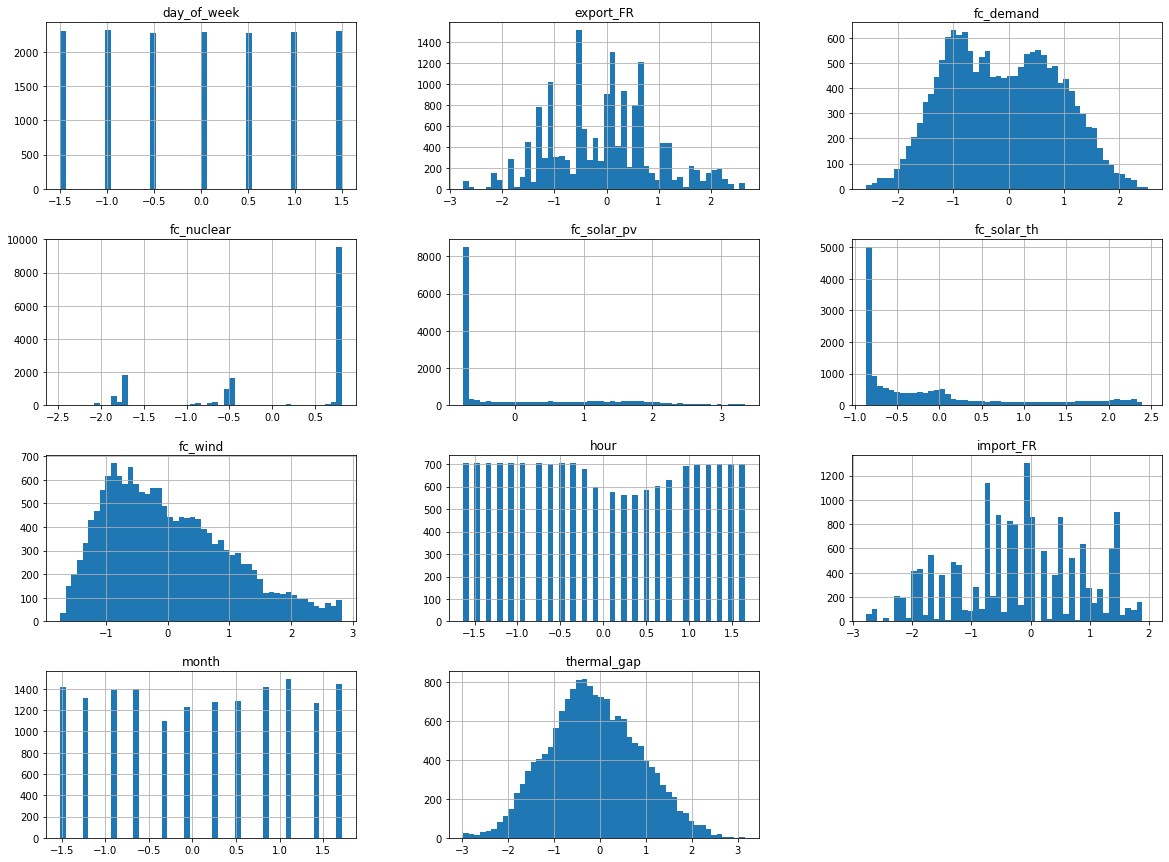

In [91]:
x_train.hist(bins=50,figsize=(20,15));

In [92]:
x_train.describe()

fc_demand  fc_nuclear  import_FR  export_FR   fc_wind  fc_solar_pv  \
count  16023.000   16023.000  16023.000  16023.000 16023.000    16023.000   
mean      -0.115       0.086     -0.188     -0.070     0.015        0.045   
std        0.997       0.999      1.073      1.004     1.000        1.096   
min       -2.574      -2.474     -2.782     -2.755    -1.740       -0.751   
25%       -0.931      -0.508     -0.794     -0.769    -0.781       -0.751   
50%       -0.155       0.812     -0.158     -0.047    -0.155       -0.729   
75%        0.671       0.812      0.557      0.585     0.665        0.824   
max        2.520       0.812      1.988      2.662     2.825        3.347   

       fc_solar_th      hour     month  day_of_week  thermal_gap  
count    16023.000 16023.000 16023.000    16023.000    16023.000  
mean        -0.073    -0.008     0.110       -0.002       -0.133  
std          0.951     1.009     1.033        0.999        0.991  
min         -0.866    -1.632    -1.518       -1.497       -2.977  
25%         -0.831    -0.918    -0.930       -0.998       -0.822  
50%         -0.461    -0.061     0.246        0.000       -0.180  
75%          0.252     0.939     1.129        0.998        0.550  
max          2.465     1.654     1.717        1.497        3.158

## 4.4 Run Different Models

In [93]:
# General 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# Linear Regression
from sklearn.linear_model import LinearRegression

# Regularized Lin Regr Models
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

# RandomForest
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

# XGBoost
from sklearn.ensemble import GradientBoostingRegressor

In [94]:
# Define time_series split for cross-validation
time_split = TimeSeriesSplit(n_splits=10)

In the following, we will run a few basic models without any feature engineering or parameter tuning (default parameters) to check how they are performing against each other and set a baseline: 
- Linear Regression
- Lasso
- Ridge
- ElasticNet
- Decision Tree
- Random Forest
- Gradient Boosting
- XGBoost

In [95]:
## Cross-validation Basic Model
# Define model
lin_baseline = LinearRegression()

# Train and predict
scores = cross_val_score(lin_baseline, x_train, y_train, scoring = "neg_mean_squared_error", cv=time_split)
lin_baseline_scores = np.sqrt(-scores)

# Use defined function to get mean & stdev of the scores
baseline_scores = get_scores(lin_baseline_scores, "lin_baseline")
cross_validation["lin_baseline"] = baseline_scores

# Print mean & stdev
# pd.DataFrame(cross_validation.values())

# display_scores(lin_baseline_scores)

In [96]:
# Ridge - Cross-validation Basic Model

# Define and train model
ridge_baseline = Ridge(alpha=0.5)

# Train and predict
scores = cross_val_score(ridge_baseline, x_train, y_train, scoring = "neg_mean_squared_error", cv=time_split)
ridge_baseline_scores = np.sqrt(-scores)

# Use defined function to get mean & stdev of the scores
baseline_scores = get_scores(ridge_baseline_scores, "ridge_baseline")
cross_validation["ridge_baseline"] = baseline_scores

# Print mean & stdev
# pd.DataFrame(cross_validation.values())

In [97]:
# Lasso - Cross-validation Basic Model

# Define and train model
lasso_baseline = Lasso(alpha=0.1) 

# Train and predict
scores = cross_val_score(lasso_baseline, x_train, y_train, scoring = "neg_mean_squared_error", cv=time_split)
lasso_baseline_scores = np.sqrt(-scores)

# Use defined function to get mean & stdev of the scores
baseline_scores = get_scores(lasso_baseline_scores, "lasso_baseline")
cross_validation["lasso_baseline"] = baseline_scores

# Print mean & stdev
# pd.DataFrame(cross_validation.values())

In [98]:
# Elastic Net - Cross-validation Basic Model

# Define and train model
elasticnet_baseline = ElasticNet(alpha=0.5)

# Train and predict
scores = cross_val_score(elasticnet_baseline, x_train, y_train, scoring = "neg_mean_squared_error", cv=time_split)
elasticnet_baseline_scores = np.sqrt(-scores)

# Use defined function to get mean & stdev of the scores
baseline_scores = get_scores(elasticnet_baseline_scores, "elasticnet_baseline")
cross_validation["elasticnet_baseline"] = baseline_scores

# Print mean & stdev
# pd.DataFrame(cross_validation.values())

In [99]:
# Decision Tree 

# Define and train model
dt_baseline = DecisionTreeRegressor(random_state=42)

# Train and predict
scores = cross_val_score(dt_baseline, x_train, y_train, scoring = "neg_mean_squared_error", cv=10)
dt_baseline_scores = np.sqrt(-scores)

# Use defined function to get mean & stdev of the scores
baseline_scores = get_scores(dt_baseline_scores, "dt_baseline")
cross_validation["dt_baseline"] = baseline_scores

# Print mean & stdev
# pd.DataFrame(cross_validation.values())

In [100]:
#Random Forest

# Define and train model
forest_baseline = RandomForestRegressor(random_state=42)

# Train and predict
scores = cross_val_score(forest_baseline, x_train, y_train, scoring = "neg_mean_squared_error", cv=time_split)
forest_baseline_scores = np.sqrt(-scores)

# Use defined function to get mean & stdev of the scores
baseline_scores = get_scores(forest_baseline_scores, "forest_baseline")
cross_validation["forest_baseline"] = baseline_scores

# Print mean & stdev
# pd.DataFrame(cross_validation.values())

In [101]:
# Gradient Boost

# Define and train model
gb_baseline = GradientBoostingRegressor(random_state=42)

# Train and predict
scores = cross_val_score(gb_baseline, x_train, y_train, scoring = "neg_mean_squared_error", cv=time_split)
gb_baseline_scores = np.sqrt(-scores)

# Use defined function to get mean & stdev of the scores
baseline_scores = get_scores(gb_baseline_scores, "gb_baseline")
cross_validation["gb_baseline"] = baseline_scores

# Print mean & stdev
# pd.DataFrame(cross_validation.values())

In [102]:
# XG Boost

import xgboost

# Define an train model
xgb_baseline = xgboost.XGBRegressor(random_state=42, objective = "reg:squarederror")

# Train and predict
scores = cross_val_score(xgb_baseline, x_train, y_train, scoring = "neg_mean_squared_error", cv=time_split)
xgb_baseline_scores = np.sqrt(-scores)

# Use defined function to get mean & stdev of the scores
baseline_scores = get_scores(xgb_baseline_scores, "xgb_baseline")
cross_validation["xgb_baseline"] = baseline_scores

# Print mean & stdev
# pd.DataFrame(cross_validation.values())

In [103]:
# Assessing feature importance in trained model

# fitting one instance
xgb_baseline.fit(x_train, y_train)

# getting feature importance of the fitted model

feat_imp = xgb_baseline.feature_im
portances_
features = x_train.columns
feat_imp_xgb_baseline = pd.DataFrame({
    "feature": features, 
    "importance": feat_imp
}).sort_values(by="importance", ascending=False).reset_index(drop=True)
feat_imp_xgb_baseline

feature  importance
0   thermal_gap       0.341
1         month       0.224
2    fc_nuclear       0.148
3     export_FR       0.094
4     import_FR       0.087
5   fc_solar_pv       0.027
6     fc_demand       0.019
7       fc_wind       0.019
8   fc_solar_th       0.016
9   day_of_week       0.015
10         hour       0.011

**Comparing the mean RMSE score across all  models**

In [104]:
results_baseline = pd.DataFrame(cross_validation.values())
results_baseline

Cross Validation                                        RMSE Scores  \
0         lin_baseline  [4.58, 19.36, 8.29, 14.48, 12.73, 12.28, 22.15...   
1       ridge_baseline  [4.57, 19.35, 8.29, 14.48, 12.73, 12.28, 22.15...   
2       lasso_baseline  [5.89, 17.83, 8.41, 13.56, 12.74, 12.25, 22.01...   
3  elasticnet_baseline  [7.69, 13.29, 10.02, 11.79, 12.0, 12.32, 21.21...   
4          dt_baseline  [22.21, 18.62, 11.52, 17.89, 15.27, 18.03, 17....   
5      forest_baseline  [7.71, 13.6, 7.68, 7.24, 8.11, 17.7, 22.55, 14...   
6          gb_baseline  [7.44, 13.67, 6.06, 7.53, 8.83, 16.87, 21.76, ...   
7         xgb_baseline  [6.94, 13.14, 6.0, 10.04, 19.2, 16.83, 22.16, ...   

         Mean RMSE       StDev RMSE  
0 112805136545.470 338415409594.391  
1           14.223            5.041  
2           14.195            4.749  
3           13.947            4.574  
4           17.737            3.142  
5           13.248            5.873  
6           12.986            5.674  
7           14.489            5.801

We just ran our first baseline models without any tuning of parameters or additional features created. We can immediately observe that there is some issue with the Linear Regression Baseline Model, which can be attributed to the use of splitting the train_set during the cross-validation by time (scikits built in time_split). Running with regular cross-fold does result in a mean RMSE that is more in line with the others, however since we have time-series this would be incorrect. 
Overall, we can also observe that there is a very high standard deviation associated with our mean RMSE and the RMSE's for each fold are very varied, leading us to the conclusion that we can still significantly improve our model to receive more consistent results.

# 5.0 Optimizing

## 5.1 Creating new features

### Time-related

We will create some time-based variables to further analyze the relationship between energy prices and time (e.g. season, weekend vs. workday etc.)

#### Season of the year


In [105]:
# Season by calendar months
def season(df):
    if ((df['month']<=3) | (df['month']==12)):
        season = 'Winter'
    elif((df['month']>=4) & (df['month']<=6)):
        season = 'Spring'
    elif((df['month']>=7) & (df['month']<=9)):
        season = 'Summer'
    else:
        season = 'Autumn'
    return season

df["season"]=df.apply(season, axis=1)

In [106]:
df.groupby("season").agg("mean")

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
season                                                                      
Autumn  28098.398    5921.442   2505.452   2269.092 5822.495      735.222   
Spring  26660.228    5870.810   2339.321   2146.425 5149.441     1151.882   
Summer  29043.654    6904.431   2076.835   2147.539 4249.993     1156.442   
Winter  29488.427    6829.918   2781.148   2324.586 6755.593      770.822   

        fc_solar_th  price   hour     year  month  day_of_week  thermal_gap  
season                                                                       
Autumn      341.650 56.026 11.473 2017.958 10.470        2.956    15277.590  
Spring      749.081 43.576 11.424 2018.401  4.960        3.018    13739.469  
Summer      912.310 50.961 11.377 2018.280  7.921        3.004    15820.479  
Winter      282.387 49.374 11.444 2018.377  4.051        3.000    14849.789

In [107]:
df['is_winter'] = np.where(((df['month']>=10) | (df['month']==1)),1,0) # Saturday & Sundays days 5 and 6, Mo-Fr: 0-4
df['is_winter'].value_counts()

0    21023
1     9303
Name: is_winter, dtype: int64

#### Weekend vs Weekday

In [108]:
df['is_weekend'] = np.where(df['day_of_week']>=5,1,0) # Saturday & Sundays days 5 and 6, Mo-Fr: 0-4
df['is_weekend'].value_counts()

0    21636
1     8690
Name: is_weekend, dtype: int64

#### Holidays

In [109]:
#link to the code for the spanish calendar https://analisisydecision.es/calendario-dias-laborales-pandas/ 
#min_date=str(df["date"].min())
#max_date=str(df["date"].max())

#from pandas.tseries.holiday import *
#from pandas.tseries.offsets import CustomBusinessDay

#class EsBusinessCalendar(AbstractHolidayCalendar):
#   rules = [
#     Holiday('Año Nuevo', month=1, day=1, observance=sunday_to_monday),
#     Holiday('Epifanía del Señor', month=1, day=6, observance=sunday_to_monday),
#     Holiday('Viernes Santo', month=1, day=1, offset=[Easter(), Day(-2)]),
#     Holiday('Día del Trabajador', month=5, day=1, observance=sunday_to_monday),
#     Holiday('Asunción de la Virgen', month=8, day=15, observance=sunday_to_monday),
#     Holiday('Día de la Hispanidad', month=10, day=12, observance=sunday_to_monday),
#     Holiday('Todos los Santos', month=11, day=1, observance=sunday_to_monday),
#     Holiday('Día Constitución', month=12, day=6, observance=sunday_to_monday),
#     Holiday('Inmaculada Concepción', month=12, day=8, observance=sunday_to_monday),	    
#     Holiday('Navidad', month=12, day=25, observance=sunday_to_monday)
#   ]

#es_BD = CustomBusinessDay(calendar=EsBusinessCalendar())
#sdr = pd.date_range(start=min_date, end=max_date, freq=es_BD)
#cal = es_BD(sdr)
#holidays = cal.holidays(start=sdr.min(), end=sdr.max())

#df['Holiday'] = df['date'].isin(holidays)

#### Day-time

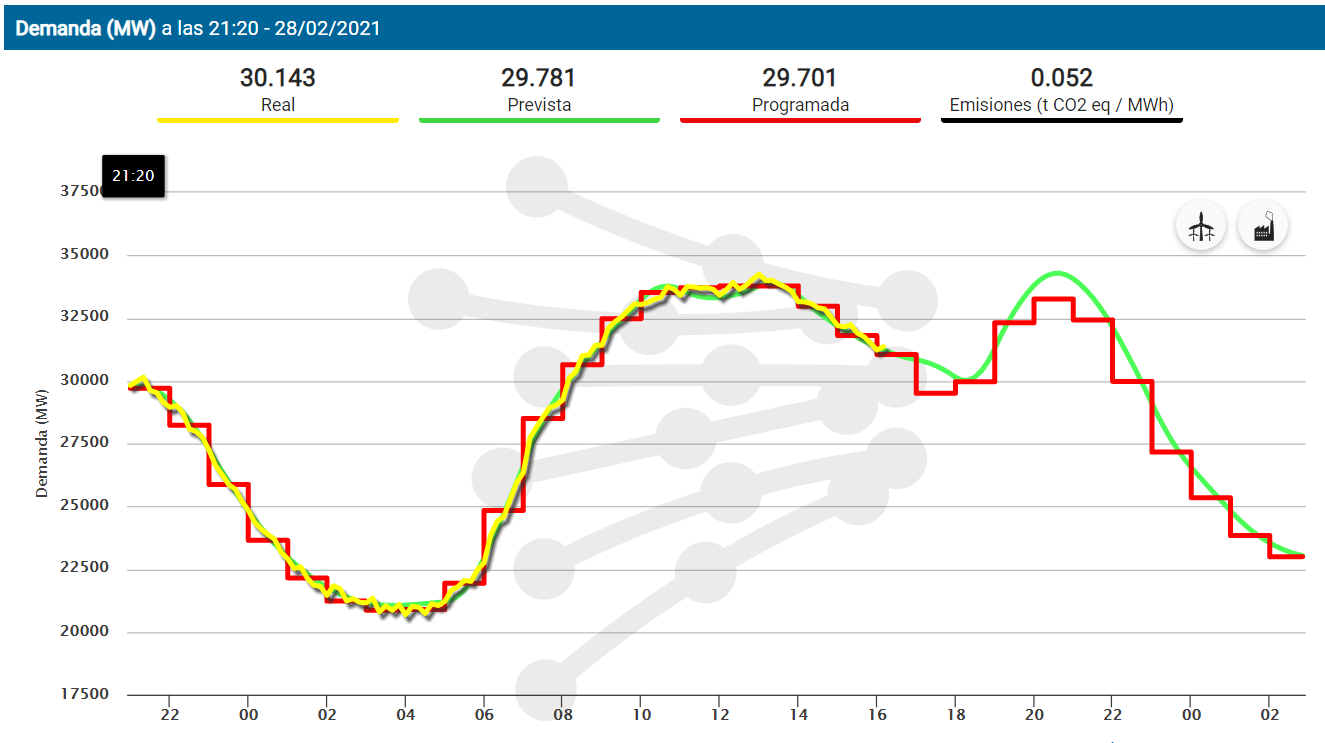

In [110]:
def moment_of_day(df):
    if (df['hour'] > 6) & (df['hour'] <= 10):
        return 'Early Morning'
    elif (df['hour'] > 10) & (df['hour'] <= 15):
        return 'Morning'
    elif (df['hour'] > 15) & (df['hour'] <= 19):
        return'Afternoon'
    elif (df['hour'] > 19) & (df['hour'] <= 23) :
        return 'Evening'
    elif (df['hour'] >= 0) & (df['hour'] <2):
        return'Night'
    elif (df['hour'] >= 2) & (df['hour'] <= 6):
        return'Late Night'

df['moment_of_day']=df.apply(moment_of_day,axis=1)

In [111]:
# We are creating a variable to account for covid, since we believe that the visible 
# drops in energy prices and demand during the covid-related lockdown could influence our model prediction
# Covid effect: 

# importing datetime module 
import datetime 

lockdown_start = datetime.datetime(2020, 3, 13) 
lockdown_end = datetime.datetime(2020, 6, 24) 


def covid(df):
    if (df['date']<lockdown_start):
        covid = 'pre_covid'
    elif((df['date']>lockdown_start) & (df['date']<lockdown_end)):
        covid = 'strict_lockdown'
    else:
        covid = 'post_lockdown'
    return covid

df["covid"]=df.apply(covid, axis=1)

#### Convert time variables into coordinates

Since we are discussing here cyclical time-series, we believe that the energy price is also influenced by the time of the day as well as time of the year. So it makes sense to train our model on these variables. However, some algorithms, especially distance-based ones (KNN etc.) would interpret time and months as actual distances, so these would consider 4am further away from midnight than 4pm. One possibility to deal with this issue is to project our time/date times onto a unit circle and then use sin and cos functions to create new features with the respective, correct distances. This results in each feature being represented by two coordinates: 

In [112]:
# Source: https://heartbeat.fritz.ai/feature-engineering-techniques-handle-date-time-and-mixed-variables-with-python-4fc97285dc14

In [113]:
import math


df["day_of_week_sin"] = df["day_of_week"].apply(lambda x: math.sin((180 - (x + 1) * (360/7))/180 * 3.141))
df["day_of_week_cos"] = df["day_of_week"].apply(lambda x: math.cos((180 - (x + 1) * (360/7))/180 * 3.141))
df["month_sin"] = df["month"].apply(lambda x: math.sin((180 - (x) * (360/12))/180 * 3.141))
df["month_cos"] = df["month"].apply(lambda x: math.cos((180 - (x) * (360/12))/180 * 3.141))
df["hr_sin"] = df["hour"].apply(lambda x: math.sin((180 - (x+1) * (360/24))/180 * 3.141))
df["hr_cos"] = df["hour"].apply(lambda x: math.cos((180 - (x+1) * (360/24))/180 * 3.141))

In [114]:
df[["day_of_week_sin","day_of_week_cos","month_sin","month_cos","hr_sin","hr_cos"]].describe()

day_of_week_sin  day_of_week_cos  month_sin  month_cos    hr_sin  \
count        30326.000        30326.000  30326.000  30326.000 30326.000   
mean             0.002           -0.002      0.046      0.034     0.017   
std              0.707            0.708      0.711      0.701     0.708   
min             -0.975           -1.000     -1.000     -1.000    -1.000   
25%             -0.782           -0.623     -0.500     -0.500    -0.707   
50%             -0.001            0.223      0.000      0.000     0.000   
75%              0.782            0.901      0.866      0.866     0.707   
max              0.975            0.901      1.000      1.000     1.000   

         hr_cos  
count 30326.000  
mean     -0.018  
std       0.706  
min      -1.000  
25%      -0.707  
50%       0.000  
75%       0.707  
max       1.000

### Energy-production

#### Ratios per production source

In [115]:
def solar_total(df):
    return ( (df['fc_solar_th'] + df['fc_solar_pv']))
df['solar_total']=df.apply(solar_total, axis=1)

#def solar_pv_ratio(df):
#    return ((df['fc_solar_pv'])/(df['fc_demand']))
#df['solar_pv_ratio']=df.apply(solar_pv_ratio, axis=1)

#def solar_th_ratio(df):
#    return ((df['fc_solar_th'])/(df['fc_demand']))
#df['solar_th_ratio']=df.apply(solar_th_ratio, axis=1)

def solar_total_ratio(df):
    return ( (df['fc_solar_th'] + df['fc_solar_pv']) / (df['fc_demand']))
df['solar_total_ratio']=df.apply(solar_total_ratio, axis=1)


def wind_ratio(df):
    return ((df['fc_wind'])/(df['fc_demand']))
df['wind_ratio']=df.apply(wind_ratio, axis=1)


def nuclear_ratio(df):
    return ((df['fc_nuclear'])/(df['fc_demand']))
df['nuclear_ratio']=df.apply(nuclear_ratio, axis=1)


def thermal_ratio(df):
    return ((df['thermal_gap'])/(df['fc_demand']))
df['thermal_ratio']=df.apply(thermal_ratio, axis=1)

#### Energy source specific variables

In [116]:
# PV is zero

# Given that PV is only produced when there is sunlight, 
# we will create a binary variable that marks at what times there will be solar pv energy (aka: sunlight)
# This can act as proxy for sunlight and human activity

df['solar_pv_iszero'] = np.where(df['fc_solar_pv']==0, 1,0)
df['solar_pv_iszero'].value_counts()

0    17140
1    13186
Name: solar_pv_iszero, dtype: int64

In [117]:
# TH Thresholds
df['solar_th_off'] = np.where(df['fc_solar_th']==0, 1,0)
df['solar_th_off'].value_counts()

0    30023
1      303
Name: solar_th_off, dtype: int64

In [118]:
# Nuclear
df["nuclear_max_capacity"] = np.where(df['fc_nuclear']>=7000, 1,0)
df['nuclear_max_capacity'].value_counts()

1    16461
0    13865
Name: nuclear_max_capacity, dtype: int64

In [119]:
# Nuclear
def nuclear_binned(df):
    if (df['fc_nuclear'] < 5000):
        return 'nuclear_4000'
    elif (df['fc_nuclear'] >= 5000) & (df['fc_nuclear'] < 6000):
        return 'nuclear_5000'
    elif (df['fc_nuclear'] >= 6000) & (df['fc_nuclear'] < 7000):
        return'nuclear_6000'
    else:
        return'nuclear_7000'

df['nuclear_binned']=df.apply(nuclear_binned,axis=1)

In [120]:
df['nuclear_binned'].value_counts()

nuclear_7000    16461
nuclear_6000     7584
nuclear_5000     6067
nuclear_4000      214
Name: nuclear_binned, dtype: int64

#### Renewables vs. non-renewables

In [121]:
# Totals
#def renew_total(df):
#    return ( (df['fc_wind']+df['fc_solar_pv']+df['fc_solar_th']))
#df['renew_total']=df.apply(renew_total, axis=1)

#def nonrenew_total(df):
#    return ((df['fc_nuclear']+df['thermal_gap']))
#df['nonrenew_total']=df.apply(nonrenew_total, axis=1)


# Differences
#def renew_diff (df):
#    return abs(df['fc_demand']-(df['fc_wind']+df['fc_solar_pv']+df['fc_solar_th']))
#df['renew_difference']=df.apply(renew_diff, axis=1)

#def nonrenew_diff (df):
#    return abs(df['fc_demand']-df['fc_nuclear']-df['thermal_gap'])
#df['non_renew_diff']=df.apply(nonrenew_diff, axis=1)


# Ratios
#def renew_ratio(df):
#    return ((df['fc_wind']+df['fc_solar_pv']+df['fc_solar_th'])/(df['fc_demand']))
#df['renew_ratio']=df.apply(renew_ratio, axis=1)

#def nonrenew_ratio(df):
#    return ((df['fc_nuclear']+df['thermal_gap'])/(df['fc_demand']))
#df['non_renew_ratio']=df.apply(nonrenew_ratio, axis=1)

#### Import/Export from France

In [1664]:
def abs_france_diff (df):
    return abs((df['import_FR']-df['export_FR']))
df['abs_france_diff']=df.apply(abs_france_diff, axis=1)

def imported_fr_ratio (df):
    return abs(df['import_FR']/df['fc_demand'])
df['imported_fr_ratio']=df.apply(imported_fr_ratio, axis=1)

def exported_fr_ratio(df):
    return abs(df['export_FR']/df['fc_demand'])
df['exported_fr_ratio']=df.apply(exported_fr_ratio, axis=1)

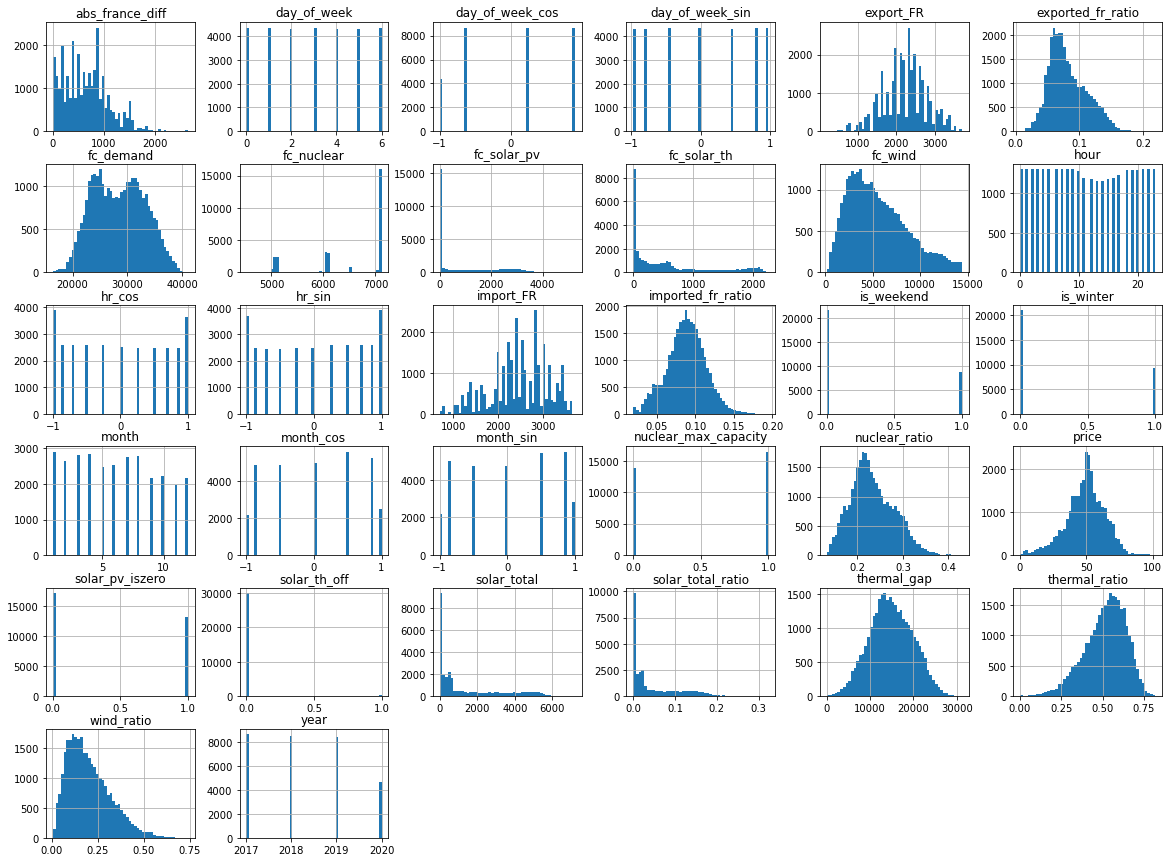

In [1665]:
df.hist(bins=50,figsize=(20,15));

### Checking for correlation/trends between variables

In [1666]:
# Calculates correlation matrix
corr = df.corr() 

# This line plots nicely visualized matrix of correlation

corr.style.background_gradient(cmap='coolwarm') 

In [1667]:
corr[["price"]].sort_values(by="price")

price
wind_ratio           -0.460
year                 -0.451
nuclear_ratio        -0.450
exported_fr_ratio    -0.358
imported_fr_ratio    -0.302
fc_wind              -0.293
month_sin            -0.245
month_cos            -0.220
hr_sin               -0.198
is_weekend           -0.151
export_FR            -0.136
day_of_week          -0.127
solar_pv_iszero      -0.118
solar_total_ratio    -0.053
solar_th_off         -0.036
fc_solar_pv          -0.024
nuclear_max_capacity  0.001
solar_total           0.010
fc_nuclear            0.019
day_of_week_sin       0.040
import_FR             0.060
hr_cos                0.075
fc_solar_th           0.075
day_of_week_cos       0.129
month                 0.156
hour                  0.208
abs_france_diff       0.219
is_winter             0.269
fc_demand             0.545
thermal_ratio         0.611
thermal_gap           0.689
price                 1.000

In [1995]:
# Creating a checkin
df_new_features = df.copy()

In [1996]:
# df = df_new_features
df_new_features.dtypes

fc_demand                        int64
fc_nuclear                     float64
import_FR                        int64
export_FR                        int64
fc_wind                          int64
fc_solar_pv                    float64
fc_solar_th                    float64
price                          float64
date                    datetime64[ns]
hour                             int64
year                             int64
month                            int64
day_of_week                      int64
thermal_gap                    float64
season                          object
is_winter                        int32
is_weekend                       int32
moment_of_day                   object
covid                           object
day_of_week_sin                float64
day_of_week_cos                float64
month_sin                      float64
month_cos                      float64
hr_sin                         float64
hr_cos                         float64
solar_total              

## 5.2 Perform One-Hot Encoding

In [1997]:
# Defining categorical variables requiring OneHotEncoding
categorical_cols = ["season","is_winter","is_weekend","moment_of_day","covid","nuclear_max_capacity","nuclear_binned"]
categorical_cols

['season',
 'is_winter',
 'is_weekend',
 'moment_of_day',
 'covid',
 'nuclear_max_capacity',
 'nuclear_binned']

In [1998]:
# Defining DF excl. categorical variables 
df_ex_cat = df_new_features.drop(columns=categorical_cols)

In [1999]:
# Perform One-Hot encoding on categorical variables
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown = "ignore")

# Concat the numerical and dummified categorical columns
df_new_features = pd.concat(
    # list of dataset to concat
    [ 
        df_ex_cat.reset_index(drop=True),
        pd.DataFrame(ohe.fit_transform(df_new_features[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True)
    ], 
    axis=1  # concat side-by_side
)

#df_new_features.head(5)

In [1924]:
#<df_new_features.dtypes

In [1925]:
ohe.get_feature_names()

array(['x0_Autumn', 'x0_Spring', 'x0_Summer', 'x0_Winter', 'x1_0', 'x1_1',
       'x2_0', 'x2_1', 'x3_Afternoon', 'x3_Early Morning', 'x3_Evening',
       'x3_Late Night', 'x3_Morning', 'x3_Night', 'x4_post_lockdown',
       'x4_pre_covid', 'x4_strict_lockdown', 'x5_0', 'x5_1',
       'x6_nuclear_4000', 'x6_nuclear_5000', 'x6_nuclear_6000',
       'x6_nuclear_7000'], dtype=object)

In [1926]:
corr_dumm = df_new_features.corr() 
corr_dumm[["price"]].sort_values(by="price")

price
covid_strict_lockdown       -0.471
wind_ratio                  -0.460
year                        -0.451
nuclear_ratio               -0.450
exported_fr_ratio           -0.358
imported_fr_ratio           -0.302
fc_wind                     -0.293
is_winter_0                 -0.269
moment_of_day_Late Night    -0.250
month_sin                   -0.245
season_Spring               -0.229
month_cos                   -0.220
hr_sin                      -0.198
covid_post_lockdown         -0.192
is_weekend_1                -0.151
export_FR                   -0.136
day_of_week                 -0.127
solar_pv_iszero             -0.118
nuclear_binned_nuclear_4000 -0.081
nuclear_binned_nuclear_5000 -0.057
moment_of_day_Night         -0.056
solar_total_ratio           -0.053
solar_th_off                -0.036
fc_solar_pv                 -0.024
nuclear_max_capacity_0      -0.001
nuclear_max_capacity_1       0.001
nuclear_binned_nuclear_7000  0.001
season_Winter                0.009
solar_total                  0.010
fc_nuclear                   0.019
day_of_week_sin              0.040
moment_of_day_Afternoon      0.047
moment_of_day_Early Morning  0.057
import_FR                    0.060
nuclear_binned_nuclear_6000  0.067
season_Summer                0.071
hr_cos                       0.075
fc_solar_th                  0.075
moment_of_day_Morning        0.095
moment_of_day_Evening        0.112
day_of_week_cos              0.129
is_weekend_0                 0.151
month                        0.156
season_Autumn                0.189
hour                         0.208
abs_france_diff              0.219
is_winter_1                  0.269
covid_pre_covid              0.499
fc_demand                    0.545
thermal_ratio                0.611
thermal_gap                  0.689
price                        1.000

Based on the correlation analysis, we will drop variables that have no correlation with price and would only introduce unnecessary noise. In the following section, we will go through several combinations of variables to detect which are most meaningful.

In [1927]:
df_new_features = df_new_features.drop(columns=["nuclear_max_capacity_1","nuclear_max_capacity_0"])

## 5.3 Re-run the models with the new features

### Scaling the Data

In [1928]:
# columns_to_scale = df_new_features.columns[(df_new_features.dtypes!='datetime64') | (df_new_features.dtypes!='object') | (df_new_features.dtypes!='int32')].tolist()
columns_to_scale = ["year","month","hour","fc_demand","fc_nuclear","import_FR","export_FR","fc_wind","solar_total","thermal_gap","abs_france_diff"]

# columns_to_scale.remove("price")
columns_to_scale

['year',
 'month',
 'hour',
 'fc_demand',
 'fc_nuclear',
 'import_FR',
 'export_FR',
 'fc_wind',
 'solar_total',
 'thermal_gap',
 'abs_france_diff']

In [1929]:
# Define Scaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler

df_new_features_scaled = df_new_features.copy()

StandardScaler
stsc = StandardScaler()

#columns_to_scale = ["year","hour","month"]

#Standardize df_scaled
for col in columns_to_scale:
    standardscaler = stsc.fit(df_new_features_scaled[[col]])
    df_new_features_scaled[col] = standardscaler.transform(df_new_features_scaled[[col]])
    
# RobustScaler
# rsc = RobustScaler()

In [1930]:
df_new_features_scaled

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0         -0.863       0.812      0.875      0.676   -1.230        0.000   
1         -1.030       0.812      0.875      0.766   -1.200        0.000   
2         -1.398       0.812      0.875      0.766   -1.201        0.000   
3         -1.653       0.812      0.875      0.766   -1.215        0.000   
4         -1.886       0.812      0.875      0.766   -1.225        0.000   
...          ...         ...        ...        ...      ...          ...   
30321      0.081       0.812     -0.397     -0.859   -0.873     2035.000   
30322      0.214       0.812     -0.397     -0.859   -0.868      325.800   
30323      0.476       0.812     -0.397     -0.859   -0.869        0.000   
30324      0.053       0.812     -0.397     -0.859   -0.897        0.000   
30325     -0.379       0.812     -0.397     -0.859   -0.905        0.000   

       fc_solar_th  price       date   hour  ...  moment_of_day_Late Night  \
0            5.100 58.820 2017-01-01 -1.632  ...                     0.000   
1            0.600 58.230 2017-01-01 -1.490  ...                     0.000   
2            4.600 51.950 2017-01-01 -1.347  ...                     1.000   
3            9.700 47.270 2017-01-01 -1.204  ...                     1.000   
4           24.100 45.490 2017-01-01 -1.061  ...                     1.000   
...            ...    ...        ...    ...  ...                       ...   
30321     1615.400 47.880 2020-08-31  1.082  ...                     0.000   
30322     1017.300 51.180 2020-08-31  1.225  ...                     0.000   
30323      682.500 55.690 2020-08-31  1.368  ...                     0.000   
30324      598.300 50.770 2020-08-31  1.511  ...                     0.000   
30325      617.800 45.000 2020-08-31  1.654  ...                     0.000   

       moment_of_day_Morning  moment_of_day_Night  covid_post_lockdown  \
0                      0.000                1.000                0.000   
1                      0.000                1.000                0.000   
2                      0.000                0.000                0.000   
3                      0.000                0.000                0.000   
4                      0.000                0.000                0.000   
...                      ...                  ...                  ...   
30321                  0.000                0.000                1.000   
30322                  0.000                0.000                1.000   
30323                  0.000                0.000                1.000   
30324                  0.000                0.000                1.000   
30325                  0.000                0.000                1.000   

       covid_pre_covid  covid_strict_lockdown  nuclear_binned_nuclear_4000  \
0                1.000                  0.000                        0.000   
1                1.000                  0.000                        0.000   
2                1.000                  0.000                        0.000   
3                1.000                  0.000                        0.000   
4                1.000                  0.000                        0.000   
...                ...                    ...                          ...   
30321            0.000                  0.000                        0.000   
30322            0.000                  0.000                        0.000   
30323            0.000                  0.000                        0.000   
30324            0.000                  0.000                        0.000   
30325            0.000                  0.000                        0.000   

       nuclear_binned_nuclear_5000  nuclear_binned_nuclear_6000  \
0                            0.000                        0.000   
1                            0.000                        0.000   
2                            0.000                        0.000   
3                            0.000                        0.000

### 5.4 Shortlist features and models

In [2064]:
# Define a function to get cross-validation scores
cross_validation_reduced = {}

def get_scores(scores, name):
    #print("Scores:",scores)
    scores_dict = {}
    scores_dict["Cross Validation"] = name
    scores_dict["RMSE Scores"] = scores.round(2)
    scores_dict["Mean RMSE"] = scores.mean().round(4)
    scores_dict["StDev RMSE"] = scores.std().round(4)
    return scores_dict

In [2065]:
df_reduced = df_new_features_scaled[["date", "price",
                                     "thermal_gap", "import_FR","export_FR", "fc_nuclear","fc_wind","solar_total",
                                     "year", "hr_sin","hr_cos","month_sin","month_cos",
                                     "covid_post_lockdown"]]
#"hr_sin","hr_cos","month_sin","month_cos",


In [2066]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25) 
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out

In [2067]:
df_reduced = remove_outlier(df_reduced,"price")

745 outliers removed


In [2068]:
#df_new_features_scaled.dtypes

In [2069]:
# Define start and end times
date_start = pd.to_datetime("2018-09-01")
date_split = pd.to_datetime("2020-09-01") # no split into test and train (data only till 2020-08-31)

# Split/reduce data
df_train_test = df_reduced # input for our model, do not remove this line
x_train, x_test, y_train, y_test = train_test_split(df_train_test, date_split )



Training Date from: 2018-09-01 00:00:00 to: 2020-09-01 00:00:00
Test Data from: 2020-09-01 00:00:00 to: 2020-08-31
x_train: (15581, 12)
x_test: (0, 12)
y_train: (15581,)
y_test: (0,)


In [2070]:
# Calculates correlation matrix
corr = df_reduced.corr() 

# Visualized matrix of correlation
corr.style.background_gradient(cmap='coolwarm') 

In [2071]:
x_train.describe()

thermal_gap  import_FR  export_FR  fc_nuclear   fc_wind  solar_total  \
count    15581.000  15581.000  15581.000   15581.000 15581.000    15581.000   
mean        -0.087     -0.202     -0.084       0.108    -0.009        0.005   
std          0.961      1.071      0.999       0.992     0.988        1.042   
min         -2.935     -2.782     -2.755      -2.474    -1.740       -0.841   
25%         -0.760     -0.794     -0.859      -0.508    -0.791       -0.818   
50%         -0.141     -0.238     -0.047       0.812    -0.178       -0.542   
75%          0.574      0.557      0.585       0.812     0.632        0.669   
max          3.158      1.988      2.662       0.812     2.825        3.109   

           year    hr_sin    hr_cos  month_sin  month_cos  covid_post_lockdown  
count 15581.000 15581.000 15581.000  15581.000  15581.000            15581.000  
mean      0.760     0.025    -0.034     -0.021     -0.038                0.078  
std       0.648     0.706     0.707      0.715      0.697                0.269  
min      -0.288    -1.000    -1.000     -1.000     -1.000                0.000  
25%       0.670    -0.707    -0.707     -0.866     -0.866                0.000  
50%       0.670     0.000     0.000     -0.001      0.000                0.000  
75%       1.627     0.707     0.707      0.500      0.500                0.000  
max       1.627     1.000     1.000      1.000      1.000                1.000

In [2072]:
# Linear Regression

## Cross-validation Basic Model
# Define model
lin_baseline = LinearRegression()

# Train and predict
scores = cross_val_score(lin_baseline, x_train, y_train, scoring = "neg_mean_squared_error", cv=time_split)
lin_baseline_scores = np.sqrt(-scores)

# Use defined function to get mean & stdev of the scores
baseline_scores = get_scores(lin_baseline_scores, "lin_reduced")
cross_validation_reduced["lin_reduced"] = baseline_scores

# Print mean & stdev
pd.DataFrame(cross_validation_reduced.values())

Cross Validation                                        RMSE Scores  \
0      lin_reduced  [4.24, 10.07, 6.63, 10.19, 13.02, 6.28, 8.69, ...   

   Mean RMSE  StDev RMSE  
0      8.143       2.557

In [2073]:
# Ridge - Cross-validation Basic Model

# Define and train model
ridge_baseline = Ridge(alpha=0.5)

# Train and predict
scores = cross_val_score(ridge_baseline, x_train, y_train, scoring = "neg_mean_squared_error", cv=time_split)
ridge_baseline_scores = np.sqrt(-scores)

# Use defined function to get mean & stdev of the scores
baseline_scores = get_scores(ridge_baseline_scores, "ridge_reduced")
cross_validation_reduced["ridge_reduced"] = baseline_scores

# Print mean & stdev
pd.DataFrame(cross_validation_reduced.values())

Cross Validation                                        RMSE Scores  \
0      lin_reduced  [4.24, 10.07, 6.63, 10.19, 13.02, 6.28, 8.69, ...   
1    ridge_reduced  [4.26, 10.05, 6.6, 10.18, 13.02, 6.3, 8.69, 5....   

   Mean RMSE  StDev RMSE  
0      8.143       2.557  
1      8.138       2.551

In [2074]:
# Lasso - Cross-validation Basic Model

# Define and train model
lasso_baseline = Lasso(alpha=0.1) 

# Train and predict
scores = cross_val_score(lasso_baseline, x_train, y_train, scoring = "neg_mean_squared_error", cv=time_split)
lasso_baseline_scores = np.sqrt(-scores)

# Use defined function to get mean & stdev of the scores
baseline_scores = get_scores(lasso_baseline_scores, "lasso_reduced")
cross_validation_reduced["lasso_reduced"] = baseline_scores

# Print mean & stdev
pd.DataFrame(cross_validation_reduced.values())

#display_scores(lasso_baseline_scores)

Cross Validation                                        RMSE Scores  \
0      lin_reduced  [4.24, 10.07, 6.63, 10.19, 13.02, 6.28, 8.69, ...   
1    ridge_reduced  [4.26, 10.05, 6.6, 10.18, 13.02, 6.3, 8.69, 5....   
2    lasso_reduced  [7.31, 10.47, 5.34, 9.31, 13.4, 8.09, 8.98, 4....   

   Mean RMSE  StDev RMSE  
0      8.143       2.557  
1      8.138       2.551  
2      8.346       2.354

In [2075]:
# Decision Tree 

# Define and train model
dt_baseline = DecisionTreeRegressor(random_state=42)

# Train and predict
scores = cross_val_score(dt_baseline, x_train, y_train, scoring = "neg_mean_squared_error", cv=time_split)
dt_baseline_scores = np.sqrt(-scores)

# Use defined function to get mean & stdev of the scores
baseline_scores = get_scores(dt_baseline_scores, "dt_reduced")
cross_validation_reduced["dt_reduced"] = baseline_scores

# Print mean & stdev
pd.DataFrame(cross_validation_reduced.values())

Cross Validation                                        RMSE Scores  \
0      lin_reduced  [4.24, 10.07, 6.63, 10.19, 13.02, 6.28, 8.69, ...   
1    ridge_reduced  [4.26, 10.05, 6.6, 10.18, 13.02, 6.3, 8.69, 5....   
2    lasso_reduced  [7.31, 10.47, 5.34, 9.31, 13.4, 8.09, 8.98, 4....   
3       dt_reduced  [8.77, 12.48, 5.41, 18.59, 17.47, 6.11, 18.55,...   

   Mean RMSE  StDev RMSE  
0      8.143       2.557  
1      8.138       2.551  
2      8.346       2.354  
3     11.271       4.960

In [2076]:
#Random Forest

# Define and train model
forest_baseline = RandomForestRegressor(random_state=42)

# Train and predict
scores = cross_val_score(forest_baseline, x_train, y_train, scoring = "neg_mean_squared_error", cv=time_split)
forest_baseline_scores = np.sqrt(-scores)

# Use defined function to get mean & stdev of the scores
baseline_scores = get_scores(forest_baseline_scores, "forest_reduced")
cross_validation_reduced["forest_reduced"] = baseline_scores

# Print mean & stdev
pd.DataFrame(cross_validation_reduced.values())

# display_scores(forest_baseline_scores)

Cross Validation                                        RMSE Scores  \
0      lin_reduced  [4.24, 10.07, 6.63, 10.19, 13.02, 6.28, 8.69, ...   
1    ridge_reduced  [4.26, 10.05, 6.6, 10.18, 13.02, 6.3, 8.69, 5....   
2    lasso_reduced  [7.31, 10.47, 5.34, 9.31, 13.4, 8.09, 8.98, 4....   
3       dt_reduced  [8.77, 12.48, 5.41, 18.59, 17.47, 6.11, 18.55,...   
4   forest_reduced  [8.96, 9.29, 4.28, 17.56, 13.64, 5.37, 16.22, ...   

   Mean RMSE  StDev RMSE  
0      8.143       2.557  
1      8.138       2.551  
2      8.346       2.354  
3     11.271       4.960  
4     10.059       4.225

In [2077]:
# XG Boost

import xgboost

# Define an train model
xgb_baseline = xgboost.XGBRegressor(random_state=42)

# Train and predict
scores = cross_val_score(xgb_baseline, x_train, y_train, scoring = "neg_mean_squared_error", cv=time_split)
xgb_baseline_scores = np.sqrt(-scores)

# Use defined function to get mean & stdev of the scores
baseline_scores = get_scores(xgb_baseline_scores, "xgb_reduced")
cross_validation_reduced["xgb_reduced"] = baseline_scores

# Print mean & stdev
pd.DataFrame(cross_validation_reduced.values())

# display_scores(forest_baseline_scores)

Cross Validation                                        RMSE Scores  \
0      lin_reduced  [4.24, 10.07, 6.63, 10.19, 13.02, 6.28, 8.69, ...   
1    ridge_reduced  [4.26, 10.05, 6.6, 10.18, 13.02, 6.3, 8.69, 5....   
2    lasso_reduced  [7.31, 10.47, 5.34, 9.31, 13.4, 8.09, 8.98, 4....   
3       dt_reduced  [8.77, 12.48, 5.41, 18.59, 17.47, 6.11, 18.55,...   
4   forest_reduced  [8.96, 9.29, 4.28, 17.56, 13.64, 5.37, 16.22, ...   
5      xgb_reduced  [7.87, 9.31, 4.81, 13.46, 5.99, 5.08, 13.81, 7...   

   Mean RMSE  StDev RMSE  
0      8.143       2.557  
1      8.138       2.551  
2      8.346       2.354  
3     11.271       4.960  
4     10.059       4.225  
5      8.836       3.052

In [2094]:
# Assessing feature importance in trained model

# fitting one instance
xgb_baseline.fit(x_train, y_train)

# getting feature importance of the fitted model
feat_imp = xgb_baseline.feature_importances_
features = x_train.columns
feat_imp_xgb_baseline = pd.DataFrame({
    "feature": features, 
    "importance": feat_imp
}).sort_values(by="importance", ascending=False).reset_index(drop=True)
feat_imp_xgb_baseline

feature  importance
0                  year       0.890
1             month_sin       0.040
2           thermal_gap       0.029
3             month_cos       0.017
4            fc_nuclear       0.011
5             import_FR       0.004
6             export_FR       0.002
7                hr_sin       0.002
8   covid_post_lockdown       0.002
9                hr_cos       0.001
10              fc_wind       0.001
11          solar_total       0.001

**Comparing the mean RMSE score across all  models**

In [2078]:
results_baseline = pd.DataFrame(cross_validation_reduced.values())
results_baseline

Cross Validation                                        RMSE Scores  \
0      lin_reduced  [4.24, 10.07, 6.63, 10.19, 13.02, 6.28, 8.69, ...   
1    ridge_reduced  [4.26, 10.05, 6.6, 10.18, 13.02, 6.3, 8.69, 5....   
2    lasso_reduced  [7.31, 10.47, 5.34, 9.31, 13.4, 8.09, 8.98, 4....   
3       dt_reduced  [8.77, 12.48, 5.41, 18.59, 17.47, 6.11, 18.55,...   
4   forest_reduced  [8.96, 9.29, 4.28, 17.56, 13.64, 5.37, 16.22, ...   
5      xgb_reduced  [7.87, 9.31, 4.81, 13.46, 5.99, 5.08, 13.81, 7...   

   Mean RMSE  StDev RMSE  
0      8.143       2.557  
1      8.138       2.551  
2      8.346       2.354  
3     11.271       4.960  
4     10.059       4.225  
5      8.836       3.052

## 6. Fine-Tune the Models

Based on above analysis, we have decided on our key features and the three main models for which we will now optimize the hyperparameters. Hyperparameter tuning is crucial as they control the overall behavior of a machine learning model, each algorithm has different hyperparameters that can be set. 

In [2079]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
time_split = TimeSeriesSplit(n_splits=10)

#### Model 1: Regularization Model

In [2080]:
# GridSearch Lasso Regression

lasso_regressor = Lasso()

# Define GridSearch Parameters
param_grid = {
    "alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    "max_iter": [1,3,10,30,50,100,500,1000,1300,1500]
}

# Define Grid Search 
grid_search = GridSearchCV(lasso_regressor, 
                           param_grid, 
                           cv=time_split, 
                           n_jobs=-1,
                           scoring = "neg_mean_squared_error", 
                           return_train_score = True,
                           refit=True)

grid_search.fit(x_train, y_train)

# Get best results/combinations
grid_search.best_params_

# alpha: default=1.0, constant that multiplies the L1 term, alpha=0 equals OLS
# noramlize: default = False, if true regressors will be normalized before regression 
# max_iter: max iterations, default= 1000
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso#sklearn.linear_model.Lasso

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70153.52738373898, tolerance: 319.17696004296903
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1, 'max_iter': 3}

In [2081]:
lasso_best_params = grid_search.best_params_
lasso_best_params

{'alpha': 0.1, 'max_iter': 3}

In [2083]:
# Get Best estimator and score
best_estimator_Lasso = grid_search.best_estimator_

print("Best Estimator:", grid_search.best_estimator_,
     "with MRSE:", np.sqrt(-grid_search.best_score_) )

Best Estimator: Lasso(alpha=0.1, max_iter=3) with MRSE: 7.960568333093954


#### Random Forest

In [2084]:
# Random Forest

forest_reg = RandomForestRegressor(random_state=42)

# Define GridSearch Parameters, based on results of Random Search
param_grid = {
    "n_estimators": [50,100],                 # default: 100
    #"min_samples_split": [2,5,8],          # default: 2 
    "min_samples_leaf": [1,2,5],             # default: 1
    "max_features": ["sqrt","auto"],       # default: auto
    "max_depth": [None, 2,8,15,25],            # default: none 
    "bootstrap": [True, False]
}

# Define Grid Search 
grid_search = GridSearchCV(forest_reg, 
                           param_grid, 
                           cv=time_split, 
                           n_jobs=-1,
                           scoring = "neg_mean_squared_error", 
                           return_train_score = True,
                           refit=True)

grid_search.fit(x_train, y_train)

# Get best results/combinations
grid_search.best_params_

# n_estimators: default 100, number of trees in the forest
# max_depth: default none, if none nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
# min_samples_split: default 2, min number of samples req. to split an internal node
# min_samples_leaf: default=1, minimum number of samples required to be at a leaf node.
# min_weight_fraction_leaf: default=0, The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. 
# max_features: default=auto, number of featuers to consider when looking for best split
# bootstrap: default=true, if false the whole dataset is used to build each tree
# From https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=randomforest%20regressor#sklearn.ensemble.RandomForestRegressor

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [2085]:
# Get Best estimator and score
best_estimator_RandomForest = grid_search.best_estimator_
print("Best Estimator:", grid_search.best_estimator_,
     "with MRSE:", np.sqrt(-grid_search.best_score_) )

Best Estimator: RandomForestRegressor(max_depth=8, random_state=42) with MRSE: 10.5617717727859


In [2086]:
# Get all evaluation scores and combinations
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

12.3563026476445 {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}
11.988798291054437 {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
12.103365498439581 {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 50}
11.706810582184238 {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}
12.332622296335204 {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 50}
11.87357074617618 {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}
10.948217548286708 {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 50}
10.91010570982609 {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}


In [2088]:
# Get feature importance 
attributes = x_train.columns

feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, attributes), reverse = True)


[(0.6182254774098822, 'year'),
 (0.2421077015488835, 'thermal_gap'),
 (0.0686433865680578, 'month_sin'),
 (0.03136943415303433, 'month_cos'),
 (0.017464134656052167, 'fc_nuclear'),
 (0.011550507693406611, 'import_FR'),
 (0.0031596960637942572, 'export_FR'),
 (0.002867387772792396, 'hr_sin'),
 (0.002331004117934633, 'fc_wind'),
 (0.0014464160632928322, 'solar_total'),
 (0.00070141330141111, 'hr_cos'),
 (0.00013344065145811418, 'covid_post_lockdown')]

#### XGBoost

In [2090]:
# XGBoost

import xgboost
xgb = xgboost.XGBRegressor(max_depth=20, random_state=42)
time_split = TimeSeriesSplit(n_splits=5)

# Define GridSearch Parameters, based on results of Random Search
param_grid = {
    "n_estimators": [50,100,150],
    "min_child_weight": [2,5],
    "max_depth": [5,8,10],
    "subsample": [0.5,0.8],
    "colsample_bytree": [0.4,0.5],
    "learning_rate": [0.05,0.1,0.2]
}

# Define Grid Search 
grid_search = GridSearchCV(xgb, 
                           param_grid, 
                           cv=time_split, 
                           n_jobs=-1,
                           scoring = "neg_mean_squared_error", 
                           return_train_score = True,
                           refit=True)

grid_search.fit(x_train, y_train)

# Get best results/combinations
grid_search.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_weight': 2,
 'n_estimators': 50,
 'subsample': 0.8}

In [2091]:
# Get Best estimator and score
best_estimator_XGB = grid_search.best_estimator_

print("Best Estimator:", grid_search.best_estimator_,
     "with MRSE:", np.sqrt(-grid_search.best_score_) )

Best Estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None) with MRSE: 9.263787781901486


In [2092]:
# Get all evaluation scores and combinations
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

9.760638695780463 {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 50, 'subsample': 0.5}
9.824831229829964 {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 50, 'subsample': 0.8}
12.650155689214317 {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.5}
12.662472184330472 {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
12.918415685748256 {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 150, 'subsample': 0.5}
12.910132562795777 {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 150, 'subsample': 0.8}
9.785364305131232 {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50, 's

In [2093]:
# Get feature importance 
attributes = x_train.columns

feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, attributes), reverse = True)


[(0.89256936, 'year'),
 (0.032011632, 'covid_post_lockdown'),
 (0.017563747, 'month_sin'),
 (0.016388698, 'thermal_gap'),
 (0.013838812, 'month_cos'),
 (0.007953356, 'import_FR'),
 (0.0074028033, 'export_FR'),
 (0.0063757515, 'fc_nuclear'),
 (0.0022000577, 'fc_wind'),
 (0.0016667815, 'solar_total'),
 (0.001494245, 'hr_sin'),
 (0.00053470564, 'hr_cos')]

#### Find best model

In [2096]:
best_estimator_Lasso

Lasso(alpha=0.1, max_iter=3)

In [2095]:
best_estimator_RandomForest

RandomForestRegressor(max_depth=8, random_state=42)

In [2097]:
best_estimator_XGB

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [2098]:
final_model = best_estimator_Lasso
final_model.fit(x_train, y_train)
final_model


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70153.52738373898, tolerance: 319.17696004296903
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1, max_iter=3)


## 7. Predict with scoring dataset

### 7.1 Import Scoring Set

In [2030]:
# Import scoring
url_scoring = "https://gist.githubusercontent.com/frau-web/d39d5cfeb92c0da9dda0f3749b6ad807/raw/4db828faad62e26b2f3a483ed53eef7416f0ed68/scoring.csv"

scoring = pd.read_csv(url_scoring)
scoring.head()


fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0  24744.000    7117.200   2300.000   1750.000 2751.000        0.000   
1  23426.000    7117.200   2300.000   2100.000 2452.000        0.000   
2  22597.000    7117.200   2300.000   2100.000 2060.000        0.000   
3  22285.000    7117.200   2300.000   2100.000 1736.000        0.000   
4  22192.000    7117.200   2300.000   2100.000 1322.000        0.000   

   fc_solar_th        date  hour  
0      627.100  2020-09-01     0  
1      606.600  2020-09-01     1  
2      528.300  2020-09-01     2  
3      598.500  2020-09-01     3  
4      474.900  2020-09-01     4

### 7.2 Perform transformations of train set on scoring set

#### Feature Engineering

In [2031]:
# Extracting datetimes
scoring['date'] = pd.to_datetime(scoring['date'], format='%Y-%m-%d')
scoring['year']= pd.DatetimeIndex(scoring['date']).year
scoring['month']= pd.DatetimeIndex(scoring['date']).month
scoring['day']= pd.DatetimeIndex(scoring['date']).day
scoring['day_of_week']=pd.DatetimeIndex(scoring['date']).dayofweek
scoring['thermal_gap']=scoring['fc_demand']-(scoring['fc_nuclear']+scoring['fc_wind']+scoring['fc_solar_pv']+scoring['fc_solar_th'])
scoring['thermal_gap'] = np.where((scoring.thermal_gap <0),0,scoring.thermal_gap)
scoring["season"]=scoring.apply(season, axis=1)
scoring['is_weekend'] = np.where(scoring['day_of_week']>=5,1,0) 
scoring['is_winter'] = np.where(((scoring['month']>=10) | (scoring['month']==1)),1,0) 
scoring['moment_of_day']=scoring.apply(moment_of_day,axis=1)
scoring['solar_total']=scoring.apply(solar_total, axis=1)
scoring['solar_total_ratio']=scoring.apply(solar_total_ratio, axis=1)
scoring['wind_ratio']=scoring.apply(wind_ratio, axis=1)
scoring['nuclear_ratio']=scoring.apply(nuclear_ratio, axis=1)
scoring['thermal_ratio']=scoring.apply(thermal_ratio, axis=1)
scoring['solar_pv_iszero'] = np.where(scoring['fc_solar_pv']==0, 1,0)
scoring['solar_th_off'] = np.where(scoring['fc_solar_th']==0, 1,0)
scoring["nuclear_max_capacity"] = np.where(scoring['fc_nuclear']>=7117, 1,0)
scoring['abs_france_diff']=scoring.apply(abs_france_diff, axis=1)
scoring['imported_fr_ratio']=scoring.apply(imported_fr_ratio, axis=1)
scoring['exported_fr_ratio']=scoring.apply(exported_fr_ratio, axis=1)
scoring['nuclear_binned']=scoring.apply(nuclear_binned,axis=1)
scoring["day_of_week_sin"] = scoring["day_of_week"].apply(lambda x: math.sin((180 - (x + 1) * (360/7))/180 * 3.141))
scoring["day_of_week_cos"] = scoring["day_of_week"].apply(lambda x: math.cos((180 - (x + 1) * (360/7))/180 * 3.141))
scoring["month_sin"] = scoring["month"].apply(lambda x: math.sin((180 - (x) * (360/12))/180 * 3.141))
scoring["month_cos"] = scoring["month"].apply(lambda x: math.cos((180 - (x) * (360/12))/180 * 3.141))
scoring["hr_sin"] = scoring["hour"].apply(lambda x: math.sin((180 - (x+1) * (360/24))/180 * 3.141))
scoring["hr_cos"] = scoring["hour"].apply(lambda x: math.cos((180 - (x+1) * (360/24))/180 * 3.141))

scoring["covid"]=scoring.apply(covid, axis=1)

#### Transformations

In [2032]:
# Check if there are null values -> NONE
# scoring.isna().sum()

In [2033]:
# OnehotEncoding
categorical_cols = ["season","is_winter","is_weekend","moment_of_day","covid","nuclear_max_capacity","nuclear_binned"]
categorical_cols

['season',
 'is_winter',
 'is_weekend',
 'moment_of_day',
 'covid',
 'nuclear_max_capacity',
 'nuclear_binned']

In [2034]:
scoring_ex_cat = scoring.drop(columns=categorical_cols)
scoring = pd.concat(
    # list of dataset to concat
    [ 
        scoring_ex_cat.reset_index(drop=True),
        pd.DataFrame(ohe.fit_transform(scoring[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True)
    ], 
    axis=1  # concat side-by_side
)


In [2035]:
columns_to_scale = scoring.columns[(scoring.dtypes!='datetime64') | (scoring.dtypes!='object') | (scoring.dtypes!='int32')].tolist()
columns_to_scale.remove("date")

In [2036]:
# Standardization
scoring_scaled = scoring.copy()

StandardScaler
stsc = StandardScaler()

#Standardize scoring_scaled
for col in columns_to_scale:
    standardscaler = stsc.fit(scoring_scaled[[col]])
    scoring_scaled[col] = standardscaler.transform(scoring_scaled[[col]])

In [2037]:
scoring_scaled.dtypes

fc_demand                             float64
fc_nuclear                            float64
import_FR                             float64
export_FR                             float64
fc_wind                               float64
fc_solar_pv                           float64
fc_solar_th                           float64
date                           datetime64[ns]
hour                                  float64
year                                  float64
month                                 float64
day                                   float64
day_of_week                           float64
thermal_gap                           float64
solar_total                           float64
solar_total_ratio                     float64
wind_ratio                            float64
nuclear_ratio                         float64
thermal_ratio                         float64
solar_pv_iszero                       float64
solar_th_off                          float64
abs_france_diff                   

#### Prediction

In [2038]:
columns_to_keep = df_reduced.columns.tolist() #columns from training model
columns_to_keep.remove("price")
columns_to_keep


['date',
 'thermal_gap',
 'import_FR',
 'export_FR',
 'fc_nuclear',
 'fc_wind',
 'solar_total',
 'year',
 'hr_sin',
 'hr_cos',
 'month_sin',
 'month_cos',
 'covid_post_lockdown']

In [2039]:
scoring_prepared = scoring_scaled[[*columns_to_keep]]
scoring_prepared = scoring_prepared.set_index('date')
scoring_prepared

thermal_gap  import_FR  export_FR  fc_nuclear  fc_wind  \
date                                                                 
2020-09-01        0.379     -0.751     -1.367       0.759   -1.162   
2020-09-01        0.211     -0.751     -0.061       0.759   -1.233   
2020-09-01        0.150     -0.751     -0.061       0.759   -1.327   
2020-09-01        0.140     -0.751     -0.061       0.759   -1.405   
2020-09-01        0.215     -0.751     -0.061       0.759   -1.504   
...                 ...        ...        ...         ...      ...   
2021-01-31       -0.982     -0.265      0.312       0.759    1.897   
2021-01-31       -0.902     -0.265      0.312       0.759    2.050   
2021-01-31       -0.994     -0.265      0.312       0.759    2.165   
2021-01-31       -1.221     -0.265      0.312       0.759    2.159   
2021-01-31       -1.462     -0.265      0.312       0.759    1.879   

            solar_total   year  hr_sin  hr_cos  month_sin  month_cos  \
date                                                                   
2020-09-01       -0.440 -0.504   0.366  -1.366     -1.130      1.795   
2020-09-01       -0.448 -0.504   0.707  -1.225     -1.130      1.795   
2020-09-01       -0.480 -0.504   1.000  -1.000     -1.130      1.795   
2020-09-01       -0.451 -0.504   1.225  -0.707     -1.130      1.795   
2020-09-01       -0.501 -0.504   1.366  -0.366     -1.130      1.795   
...                 ...    ...     ...     ...        ...        ...   
2021-01-31       -0.691  1.984  -1.225  -0.707      1.555     -0.599   
2021-01-31       -0.691  1.984  -1.001  -1.000      1.555     -0.599   
2021-01-31       -0.689  1.984  -0.708  -1.225      1.555     -0.599   
2021-01-31       -0.690  1.984  -0.367  -1.366      1.555     -0.599   
2021-01-31       -0.693  1.984  -0.001  -1.414      1.555     -0.599   

            covid_post_lockdown  
date                             
2020-09-01                0.000  
2020-09-01                0.000  
2020-09-01                0.000  
2020-09-01                0.000  
2020-09-01                0.000  
...                         ...  
2021-01-31                0.000  
2021-01-31                0.000  
2021-01-31                0.000  
2021-01-31                0.000  
2021-01-31                0.000  

[3673 rows x 12 columns]

In [2099]:
final_model

Lasso(alpha=0.1, max_iter=3)

In [2100]:
# Predict final model
#scoring_prepared = scoring_prepared.drop("date_hour")
y_pred = final_model.predict(scoring_prepared)
submission = pd.DataFrame(y_pred)
submission = submission.rename(columns={0:"y_pred"})
submission

y_pred
0     69.129
1     67.769
2     67.215
3     67.055
4     67.527
...      ...
3668  25.881
3669  26.633
3670  26.029
3671  24.299
3672  22.252

[3673 rows x 1 columns]

In [2101]:
submission.to_csv("y_pred_A.csv", index = False)

In [2062]:
submission.shape

(3673, 1)